In [ ]:
import torch
import math
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")

In [ ]:
# R = P1 + P2 + e, ks1, kf1, kb1, E10
# P1 = P2 + e, ks3, k3f, k3b, E30
# P2 + H2O = P3 + H+, k4f, k4b, deltaG4

In [ ]:
#physical Constants
F = 96485.332 #C/mol - Faraday constant
T = 298 #K - Temperature
R = 8.314 #J/mol-K - Gas const.
Beta = 0.5 #grid expansion factor 0 < BT < 1

#reaction Constants
DR = 1e-9 #m^2/s - Diffusion coeff of reactant R
DP = 1e-9 #m^2/s - Diffusion coeff of reactant P
ks1 = 1e-9 #m/s - surface rate constant of reaction 1
ks3 = 1 #m/s - surface rate constant of reaction 3
kdiff = 7.9e9  #s-1 - diffusion rate constant
#BDE0 = 29 #kcal/mol - BDE of bibenzyl radical cation
#BDE = 7 #kcal/mol - BDE of other bibenzyl models
deltaG4 = -36.37 #kcal/mol

In [ ]:
K4 = math.exp(-deltaG4 * 4.184 * 1000 / (R * T))
k4f = kdiff
k4b = k4f / K4
print("K4 =", K4)
print("k4f =", k4f)
print("k4b =", k4b)

K4 = 4.723874189899391e+26
k4f = 7900000000.0
k4b = 1.672356138715933e-17


In [ ]:
#experiment constants
nu = 0.1 #V/s- Sweep rate
Ei = 2.0 #V - initial voltage
E10 = 2.5 #V - thermodynamic reversible potential for bibenzyl oxidation into the radical cation
E30 = 0.97 #V - thermodynamic reversible potential for benzyl radical into benzyl cation
Emax = 4.0 #V - Max voltage (end for forwards sweep
Emin = 0.5 #V - Min voltage (end for backwards sweep)
dE = 0.001 #V - potential step
CR0 = 0.01 #M - bulk conc. of reactant R - MUST have a decimal!
CP00 = 0 #M - bulk conc. of product P0
CP10 = 0 #M - bulk conc. of product P1
CP20 = 0 #M - bulk conc. of product P2
CP30 = 0 #M - bulk conc. of product P3
Alpha = 0.5 #Transfer coefficient
n = 1 # # of electrons transferred
a = nu * F / (R *T)
VT = Alpha*n*F/(R*T) #V -mod. thermal voltage for n = 1

In [ ]:
dt = 0.001
dx = 7.021045531185578e-10
Ds = max([DR, DP]) * dt / (dx * dx)
print("Ds =", Ds)

tf = (Emax-Emin) / nu #s, timescale of experiment operation
xmax = 6.0*math.sqrt(max([DR,DP])*tf) #maximum diffusion distance
N = 1 + math.ceil(math.log(1 + (xmax*(math.exp(Beta) - 1)/dx) )/Beta)  #+1 for ghost pt

print("N =", N)
print("xmax =", xmax)

Ds = 2028600.0000000005
N = 29
xmax = 0.0011224972160321825


In [ ]:
#create the array of space
x = torch.empty(4*(N+1), 1, dtype = torch.double)
x[0] = 0
for k in range(1, 1+N):
  x[k] = dx * (math.exp(Beta*(k-0.5))-1) / (math.exp(Beta)-1)
for k in range(1+N, 2*N+2):
  x[k] = x[k-N-1]
for k in range(2*(N+1), 3*(N+1)):
  x[k] = x[k-2*N-2]
for k in range(3*(N+1), 4*(N+1)):
  x[k] = x[k-3*(N+1)]

print(x.shape)

torch.Size([120, 1])


In [ ]:
#calculate the normalized rate constant
dx1 = dx * (math.exp(Beta/2)-1)/(math.exp(Beta)-1)
k4fs = k4f * dt
k4bs = k4b * dt

k1f = ks1 * math.exp((Ei-E10)*VT) * dx1 / DR
k1b = ks1 * math.exp(-(Ei-E10)*VT) * dx1 / DP
k3f = ks3 * math.exp((Ei-E30)*VT) * dx1 / DR
k3b = ks3 * math.exp(-(Ei-E30)*VT) * dx1 / DP

print(dx1)
print("k1f =", k1f)
print("k1b =", k1b)
print("k3f =", k3f)
print("k3b =", k3b)
print("k4fs =", k4fs)
print("k4bs =", k4bs)

3.0739787219037986e-10
k1f = 1.817455429474267e-14
k1b = 5.199217009382569e-06
k3f = 157713640.91927186
k3b = 5.991457129287949e-10
k4fs = 7900000.0
k4bs = 1.672356138715933e-20


In [ ]:
#create tensors for the new concentration
Cnew = torch.empty(4*(N+1), 1, dtype = torch.double)
Cnew[0:N] = CR0
Cnew[N+1 : 2*N+1] = CP10
Cnew[2*N+2 : 3*N+2] = CP20
Cnew[3*N+3 : 4*N+3] = CP30

#create tensors for the old concentrations
ColdR = torch.empty(N+1, 1, dtype = torch.double)
ColdR.fill_(CR0)

Cold1 = torch.empty(N+1, 1, dtype = torch.double)
Cold1.fill_(CP10)

Cold2 = torch.empty(N+1, 1, dtype = torch.double)
Cold2.fill_(CP20)

Cold3 = torch.empty(N+1, 1, dtype = torch.double)
Cold3.fill_(CP30)

#create tensors for the old concentration
Cold = torch.empty(4*N+4, 1, dtype = torch.double)

Cold[0:N] = ColdR[0:N]

Cold[N+1 : 2*N+1] = Cold1[0 : N]

Cold[2*N+2 : 3*N+2] = Cold2[0 : N]

Cold[3*N+3 : 4*N+3] = Cold3[0 : N]

Cold[0] = k1b * Cold1[0] * Cold2[0]
Cold[N+1] = -k1b * Cold1[0] * Cold2[0]
Cold[2*N+2] = -k1b * Cold1[0] * Cold2[0]
Cold[3*N+3] = 0

Cold[N] = CR0
Cold[2*N+1] = CP10
Cold[3*N+2] = CP20
Cold[4*N+3] = CP30

#print("Cnew =", Cnew)
#print("ColdR =", ColdR)
#print("Cold0 =", Cold0)
#print("Cold1 =", Cold1)
#print("Cold2 =", Cold2)
#print("Cold3 =", Cold3)
#print("Cold =", Cold)

In [ ]:
#create tensors for the diffusion coefficients
D1 = torch.empty(N, 1, dtype = torch.double)
D2 = torch.empty(N, 1, dtype = torch.double)
D3 = torch.empty(N, 1, dtype = torch.double)

#set values for the diffusion coefficients
D1[0] = Ds * (math.exp(Beta)-1) / (math.exp(Beta/2) - 1)
D2[0] = Ds * math.exp(2*Beta*(3/4 - 1))
D3[0] = D1[0] + D2[0] + 1

for k in range(1, N):
  D1[k] = Ds * math.exp(2 * Beta * (5/4 - k - 1))
  D2[k] = Ds * math.exp(2 * Beta * (3/4 - k - 1))
  D3[k] = D1[k] + D2[k] + 1

In [ ]:
#create a tensor size (4N+4)*(4N+4) with uninitialized memory
Dopt = torch.empty(4*(N+1), 4*(N+1), dtype=torch.double).fill_(0)
Drat = DR/DP

#set values for the operator Dopt

#set values for row 0
Dopt[0] = 0
Dopt[0, 0] = -1 - k1f
Dopt[0, 1] = 1
Dopt[0, N+1] = k1b * Cold2[0]
Dopt[0, 2*N+2] = k1b * Cold1[0]

#print(Dopt[0])

In [ ]:
#set values for row N+1
Dopt[N+1] = 0
Dopt[N+1, 0] = k1f
Dopt[N+1, N+1] = -1 - k1b * Cold2[0] - k3f
Dopt[N+1, N+2] = 1
Dopt[N+1, 2*N+2] = k3b - k1b * Cold1[0]

#print(Dopt[N+1])

In [ ]:
#set values for row 2*(N+1)
Dopt[2*N+2] = 0
Dopt[2*N+2, 0] = k1f
Dopt[2*(N+1), 2*(N+1)] = -1 - k1b * Cold1[0] - k3b
Dopt[2*N+2, 2*N+3] = 1
Dopt[2*(N+1), N+1] = k3f - k1b * Cold2[0]

In [ ]:
#set values for row 3*(N+1)
Dopt[3*N+3] = 0
Dopt[3*(N+1), 3*(N+1)] = -1
Dopt[3*(N+1), 3*(N+1)+1] = 1

In [ ]:
#set values for row N
Dopt[N] = 0
Dopt[N, N] = 1

#set values for row 2N+1
Dopt[2*N+1] = 0
Dopt[2*N+1, 2*N+1] = 1

#set values for row 3*N+2
Dopt[3*N+2] = 0
Dopt[3*N+2, 3*N+2] = 1

#set values for row 4N+3
Dopt[4*N+3] = 0
Dopt[4*N+3, 4*N+3] = 1

In [ ]:
#set values for other rows for Dopt
for i in range(1, N):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-1]
  Dopt[i, i-1] = -D1[i-1]
  Dopt[i, i+1] = -D2[i-1]

for i in range(N+2, 2*N+1):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-N-2]
  Dopt[i, i-1] = -D1[i-N-2]
  Dopt[i, i+1] = -D2[i-N-2]

for i in range(2*N+3, 3*N+2):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-2*N-3] + k4fs
  Dopt[i, i-1] = -D1[i-2*N-3]
  Dopt[i, i+1] = -D2[i-2*N-3]
  Dopt[i, i+N+1] = -k4bs

for i in range(3*N+4, 4*N+3):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-3*N-4] + k4bs
  Dopt[i, i-1] = -D1[i-3*N-4]
  Dopt[i, i+1] = -D2[i-3*N-4]
  Dopt[i, i-N-1] = -k4fs

print(Dopt.shape)

torch.Size([120, 120])


In [ ]:
#Initialize potential vector
Evt = torch.cat([torch.arange((Ei+dE),(Emax+dE),dE), torch.arange(Emax, (Emin-dE), -dE), torch.arange(Emin, (Emax+dE), dE), torch.arange(Emax, (Emin-dE), -dE), torch.arange(Emin, (Ei+2*dE), dE)])

Evt = Evt.reshape(len(Evt),1)
Istor = torch.empty(len(Evt), 1, dtype=torch.double).fill_(0)
Istor1 = torch.empty(len(Evt), 1, dtype=torch.double).fill_(0)
Istor2 = torch.empty(len(Evt), 1, dtype=torch.double).fill_(0)

print(Evt.shape)
print(Istor.shape)
count = 0

torch.Size([14007, 1])
torch.Size([14007, 1])


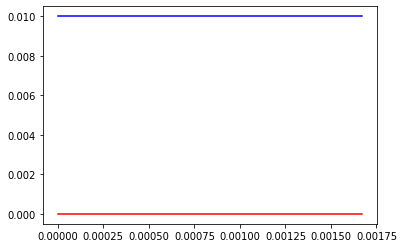

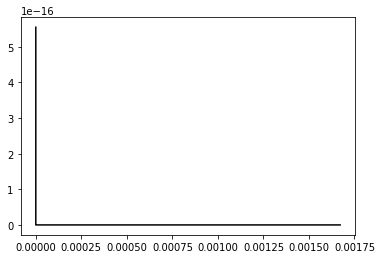

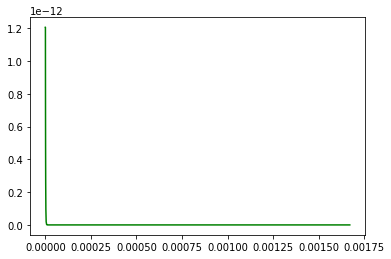

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


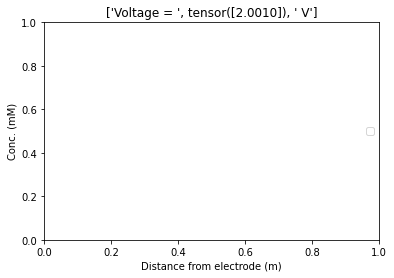

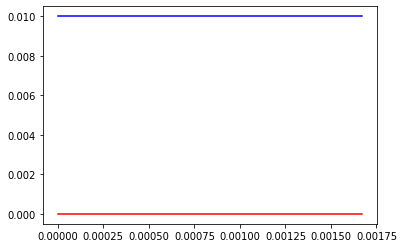

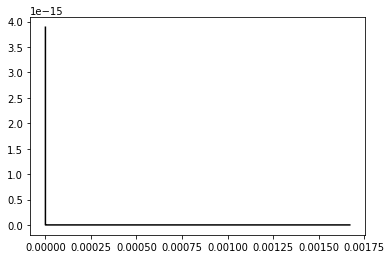

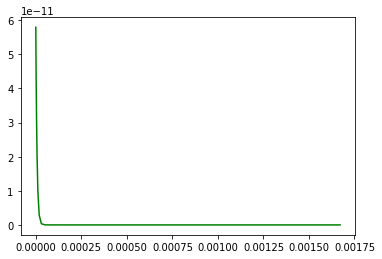

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


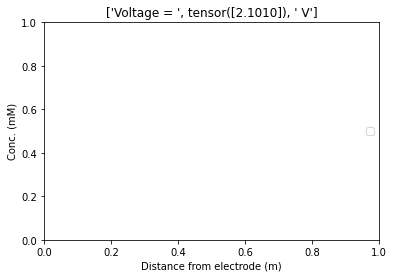

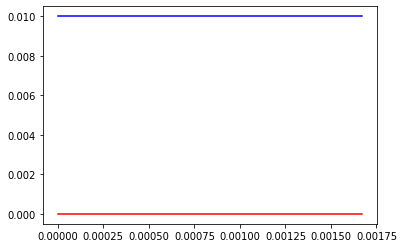

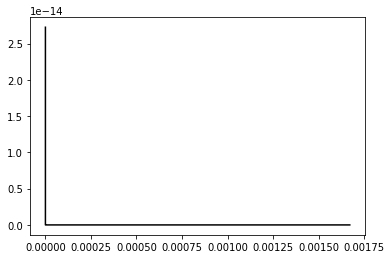

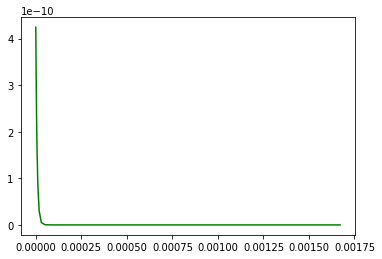

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


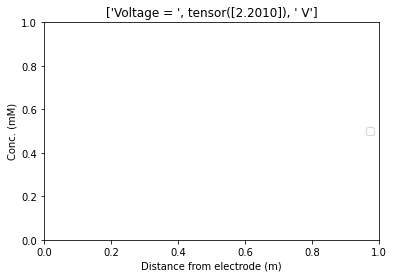

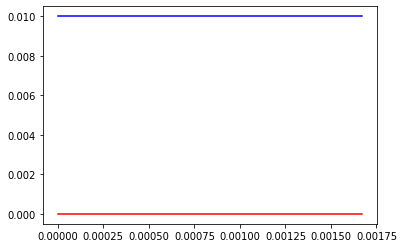

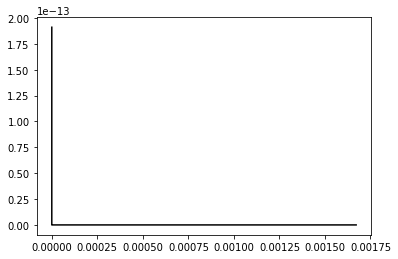

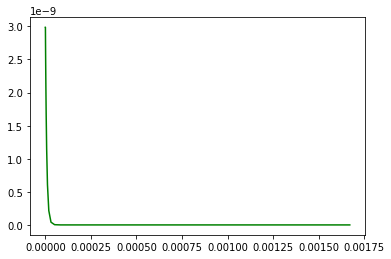

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


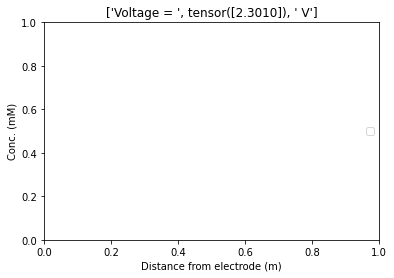

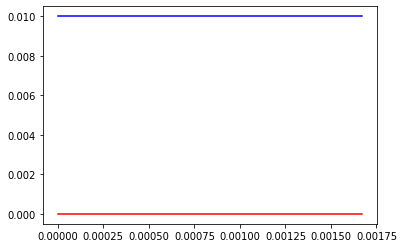

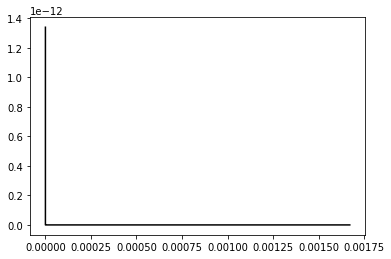

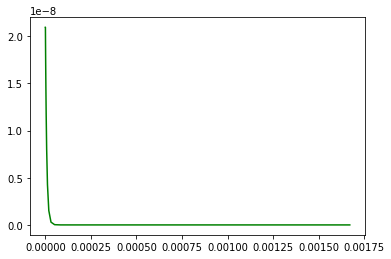

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


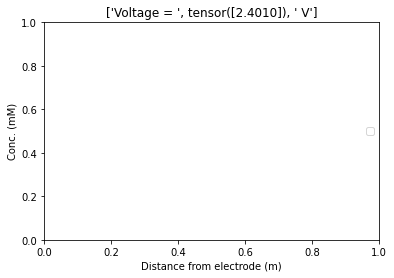

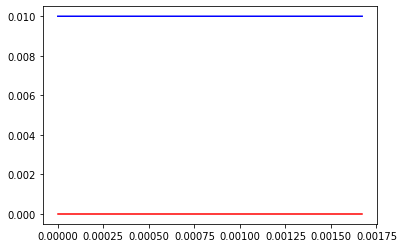

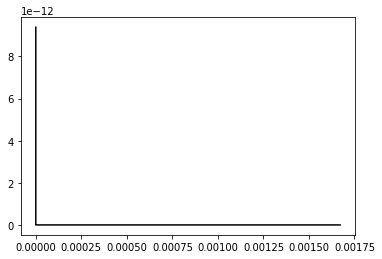

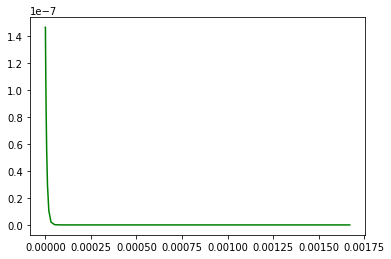

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


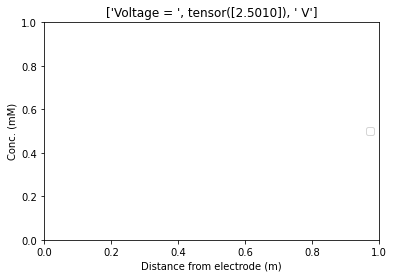

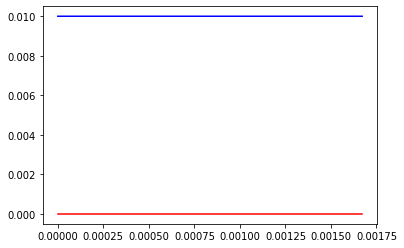

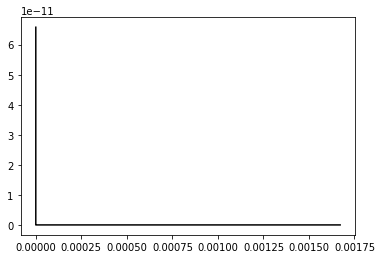

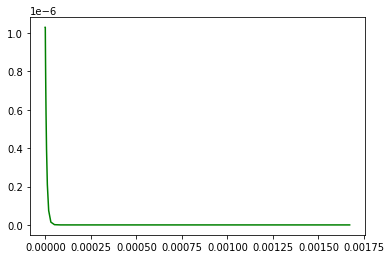

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


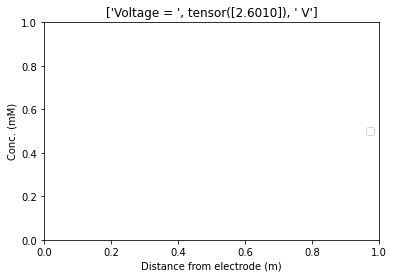

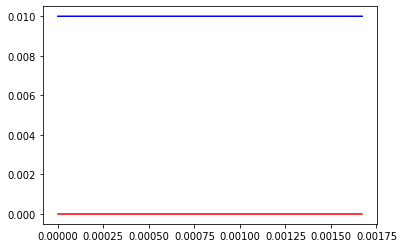

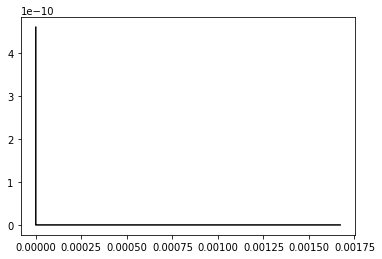

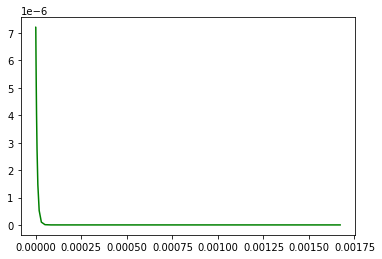

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


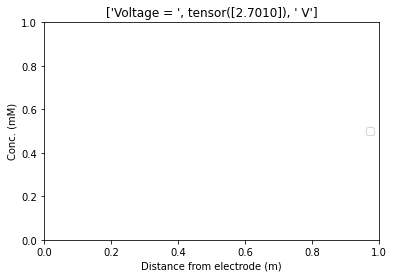

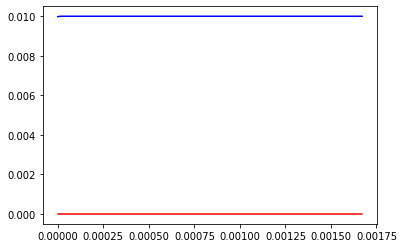

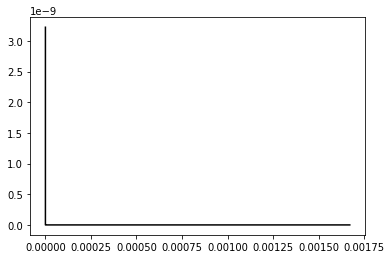

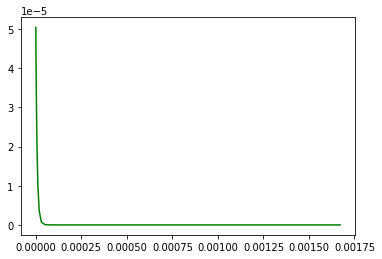

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


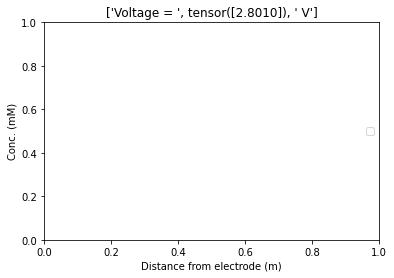

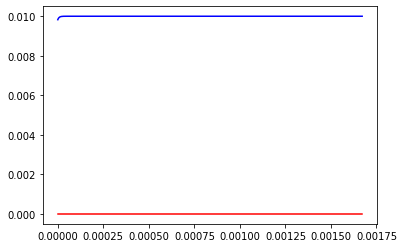

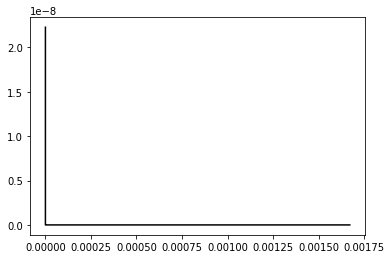

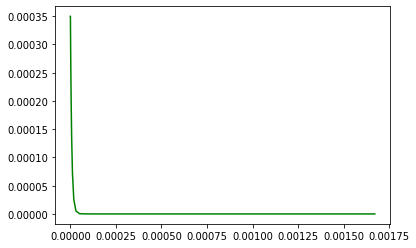

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


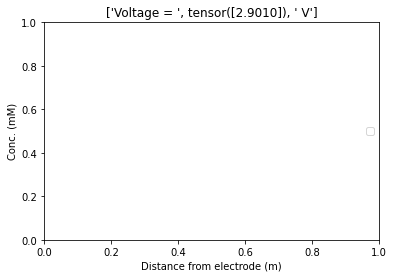

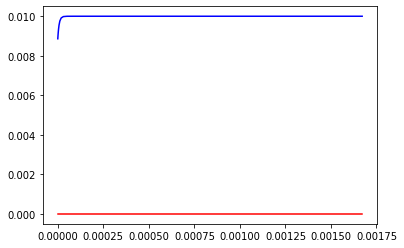

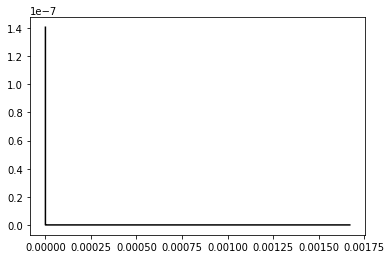

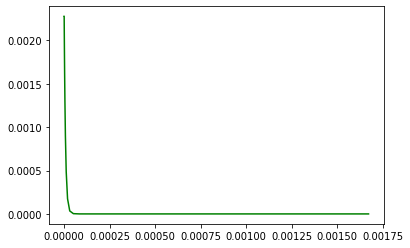

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


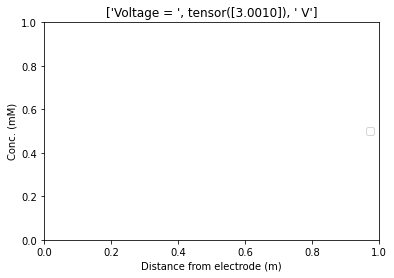

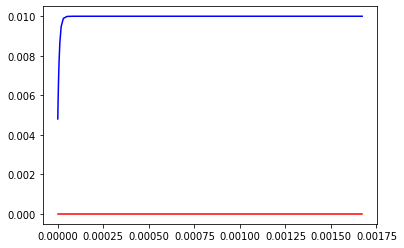

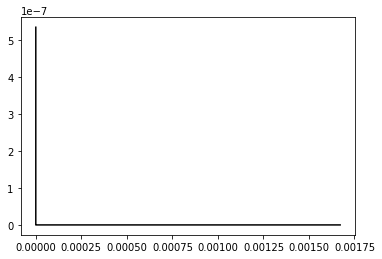

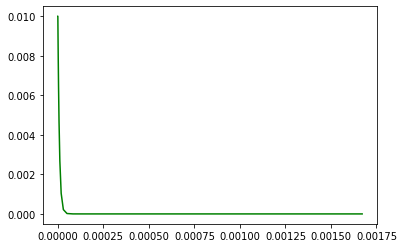

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


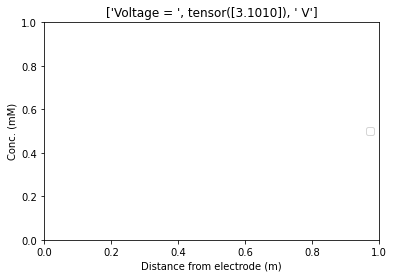

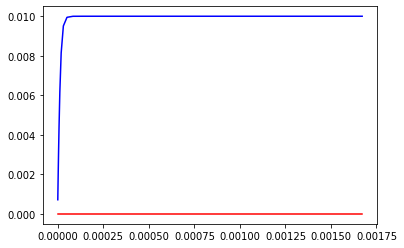

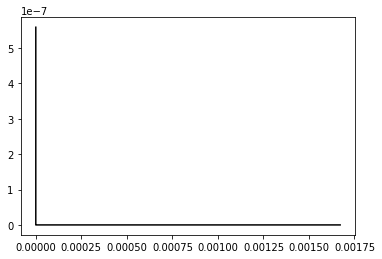

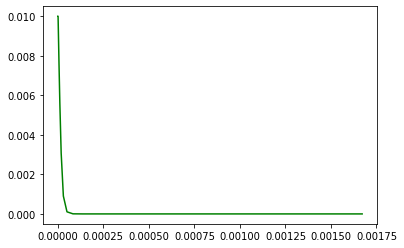

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


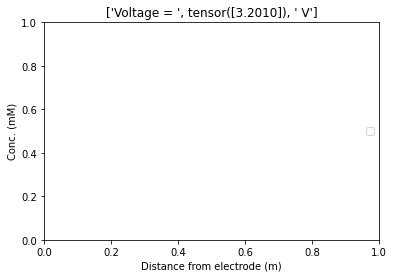

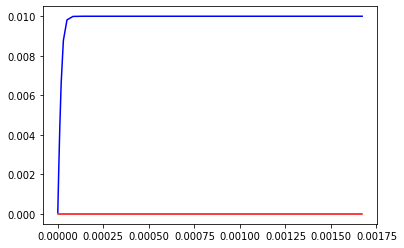

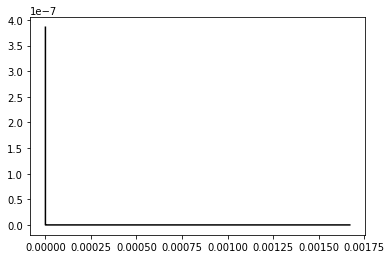

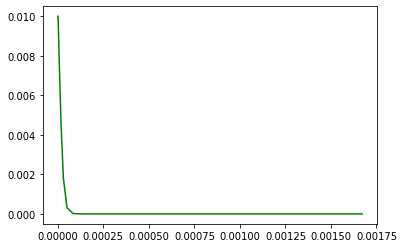

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


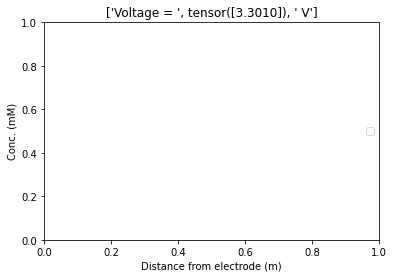

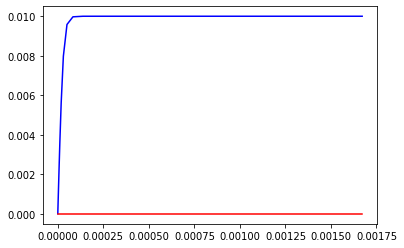

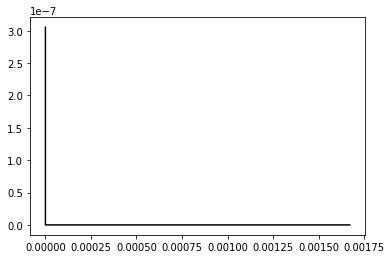

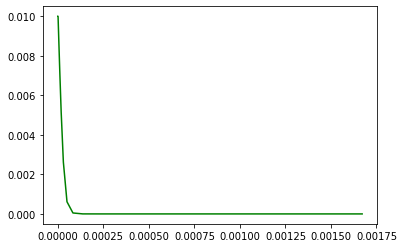

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


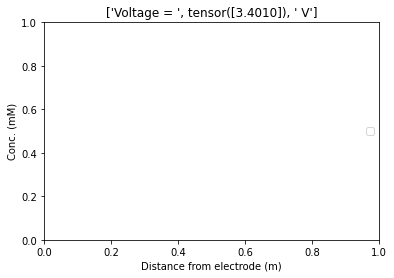

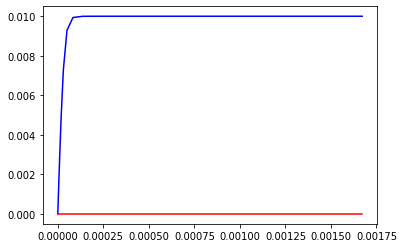

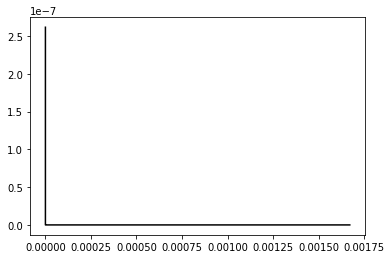

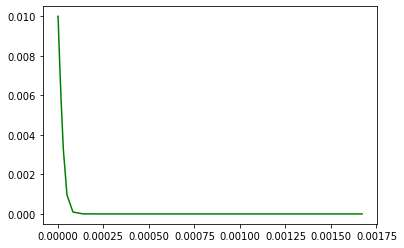

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


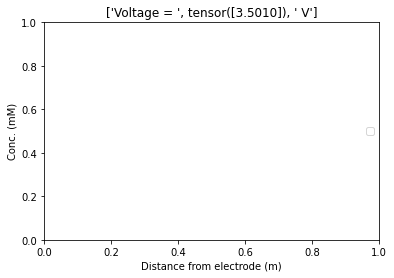

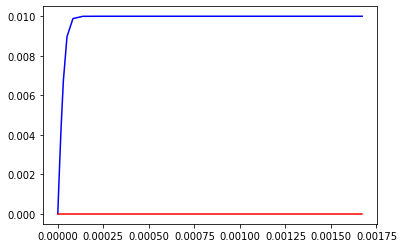

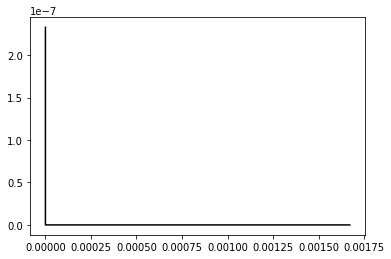

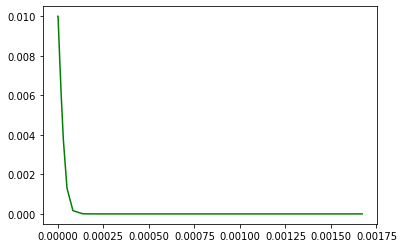

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


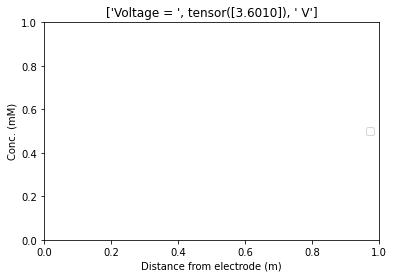

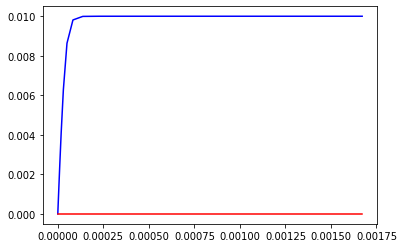

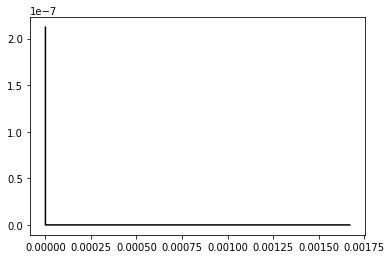

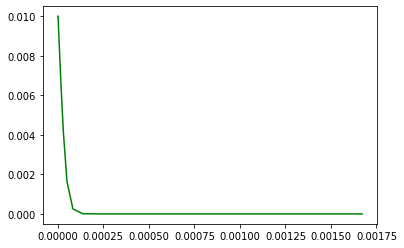

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


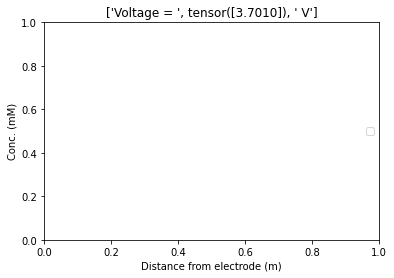

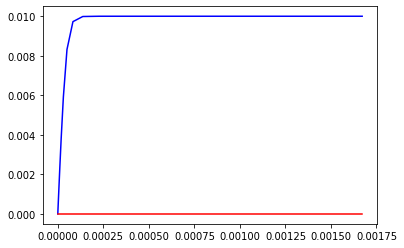

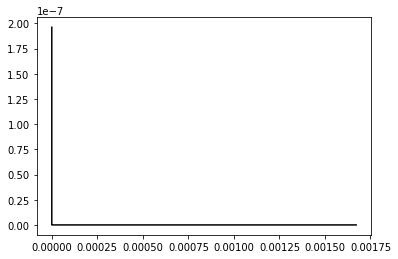

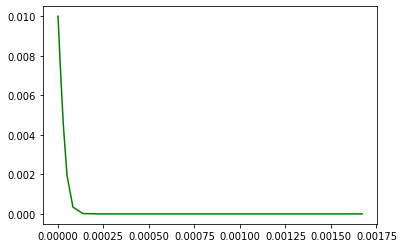

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


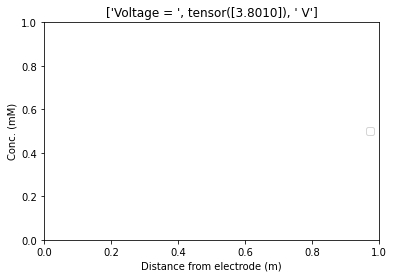

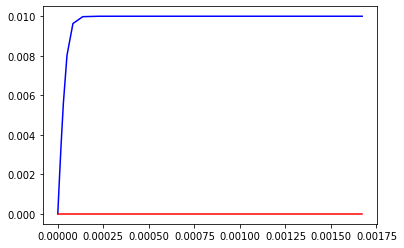

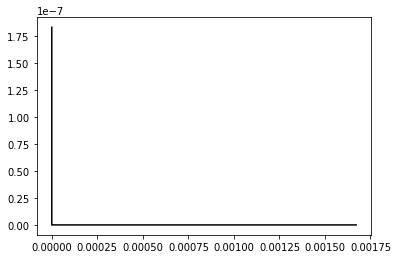

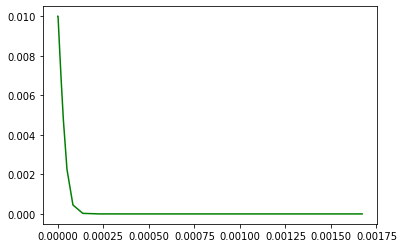

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


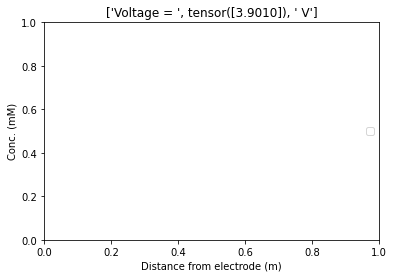

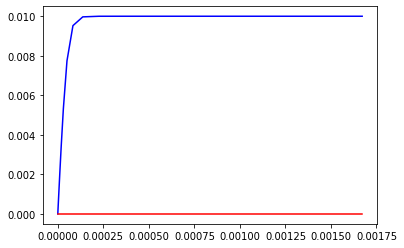

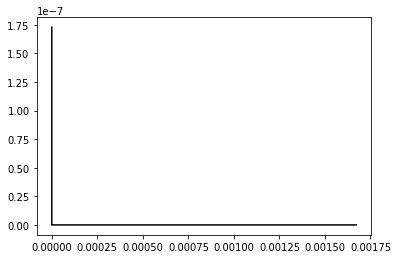

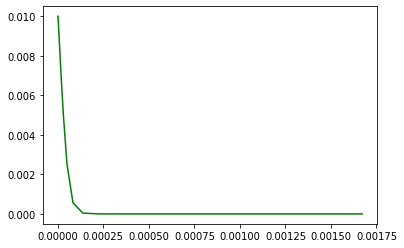

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


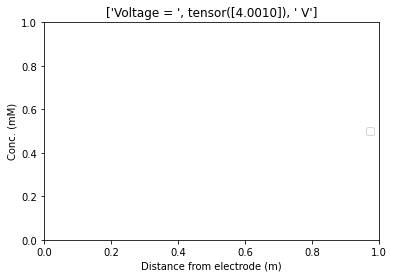

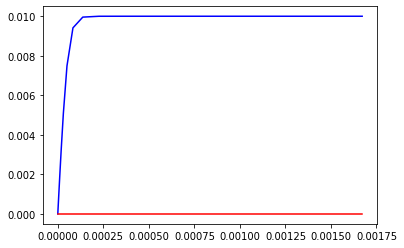

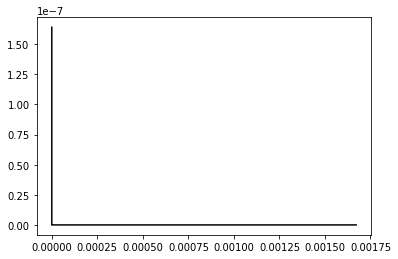

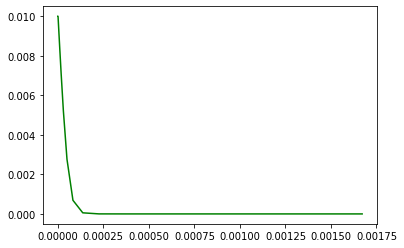

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


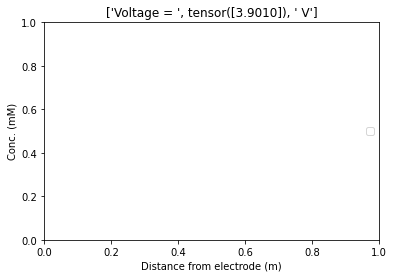

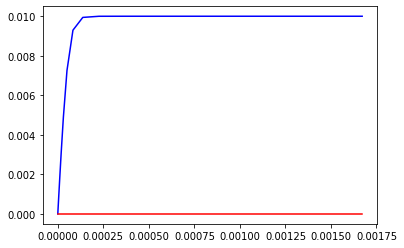

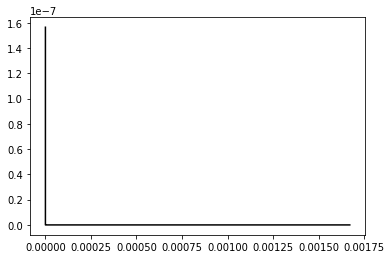

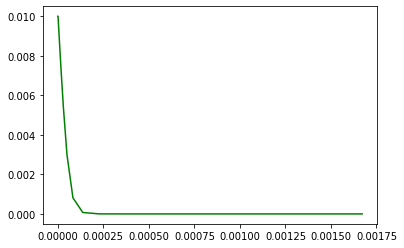

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


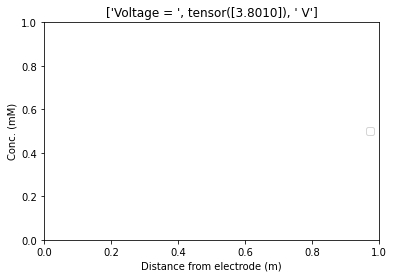

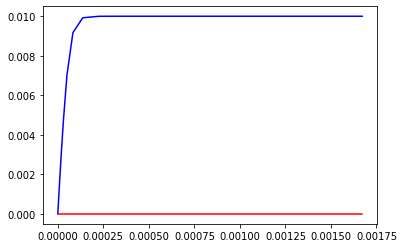

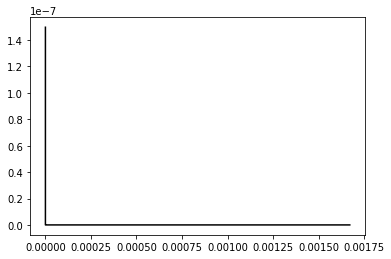

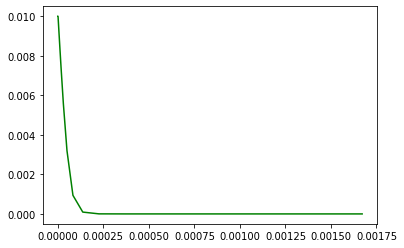

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


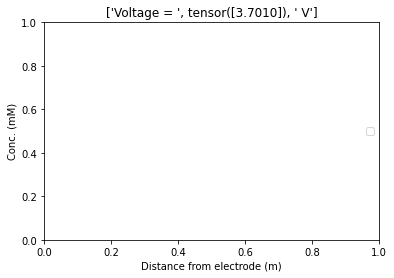

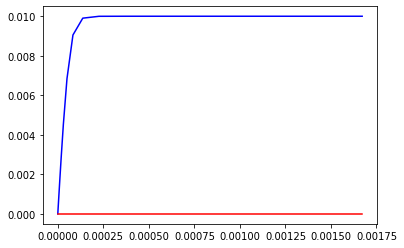

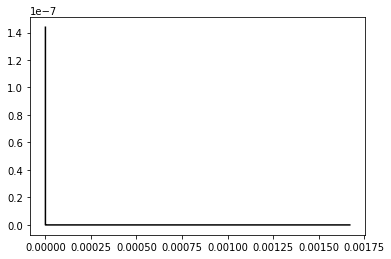

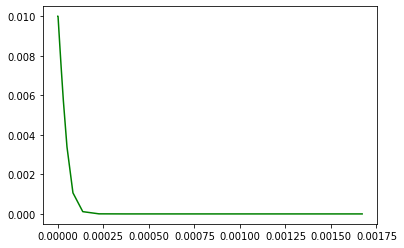

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


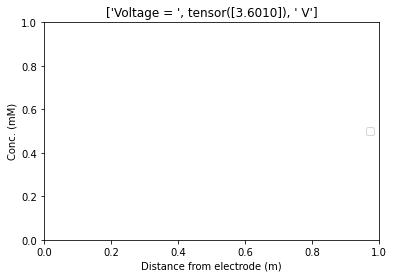

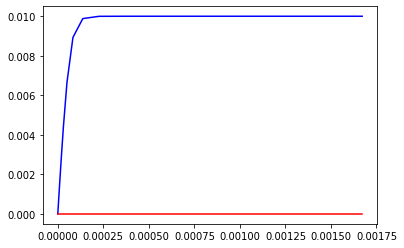

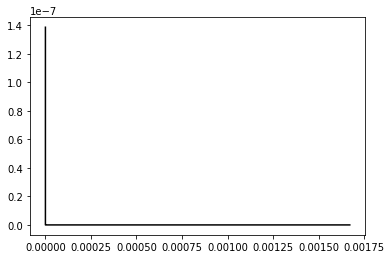

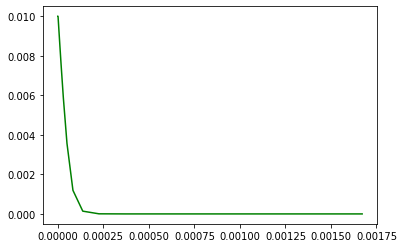

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


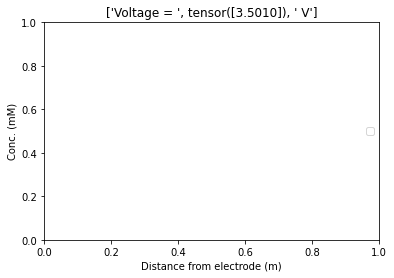

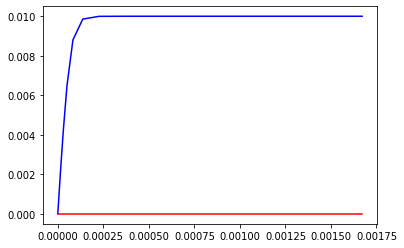

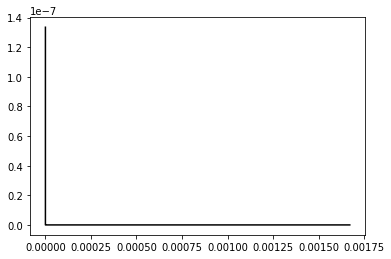

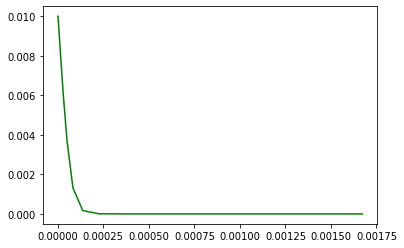

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


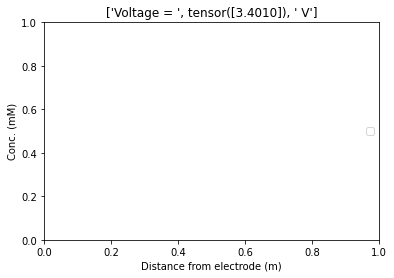

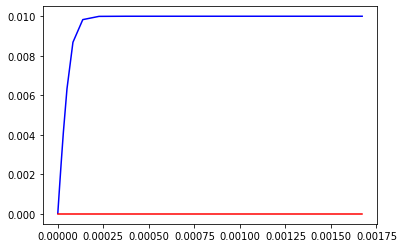

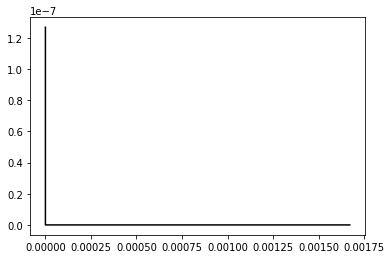

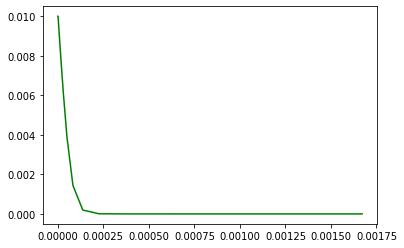

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


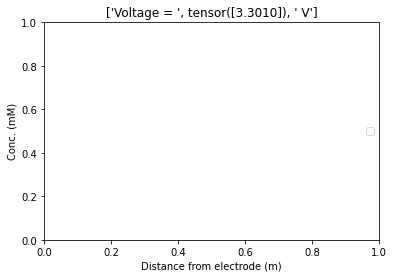

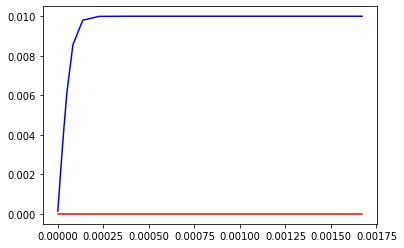

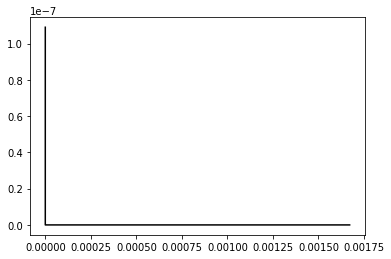

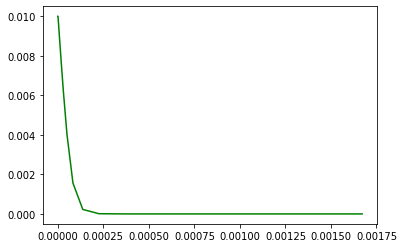

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


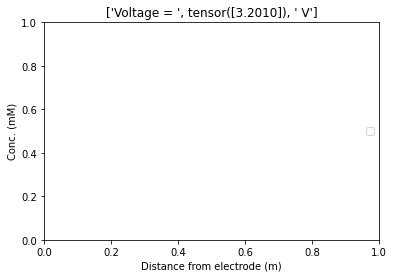

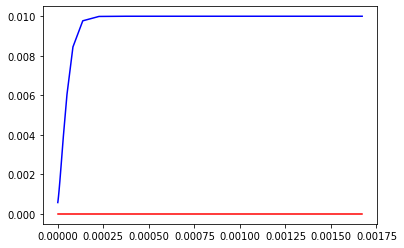

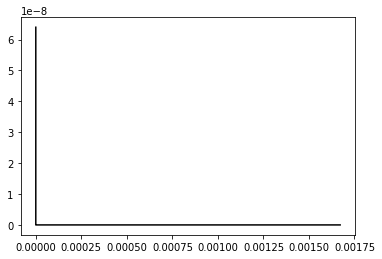

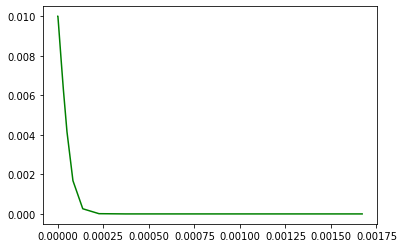

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


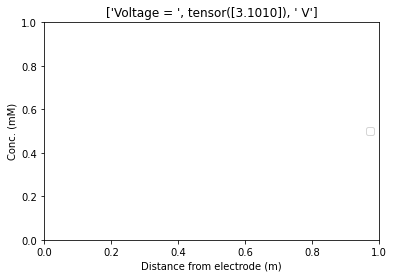

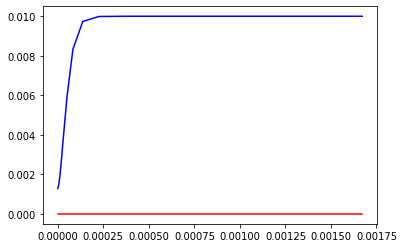

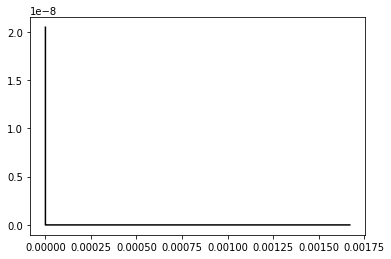

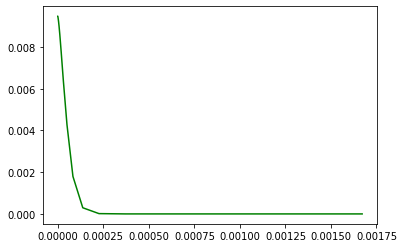

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


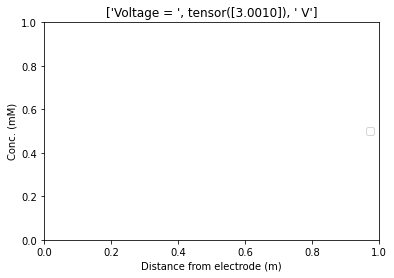

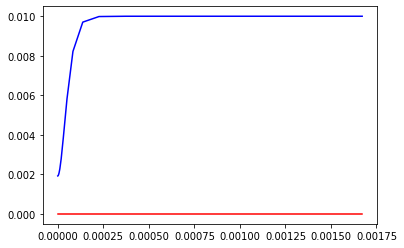

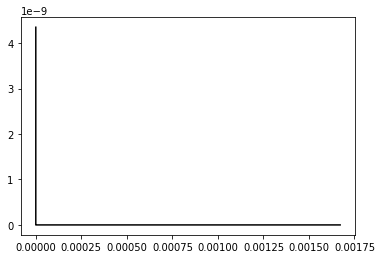

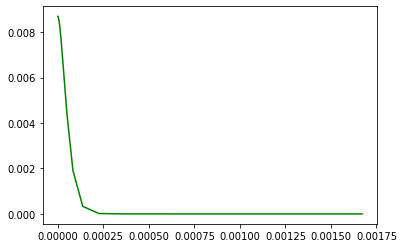

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


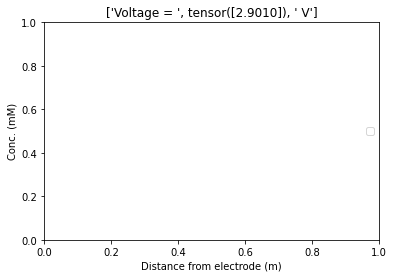

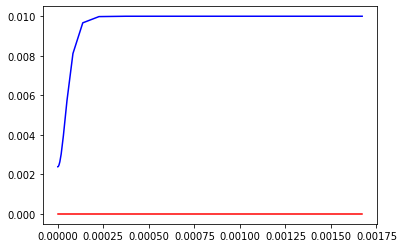

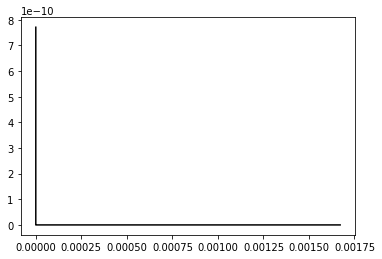

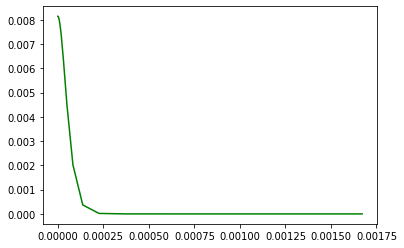

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


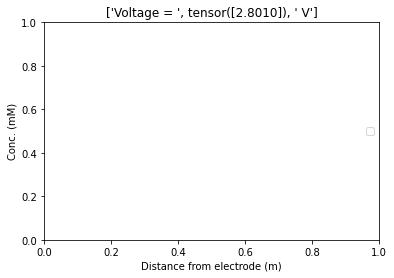

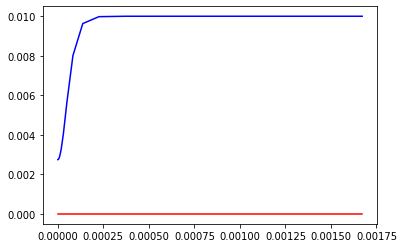

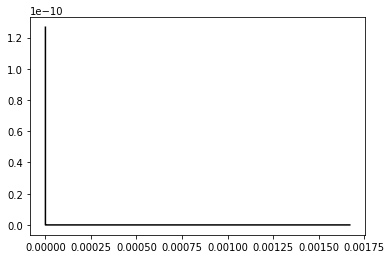

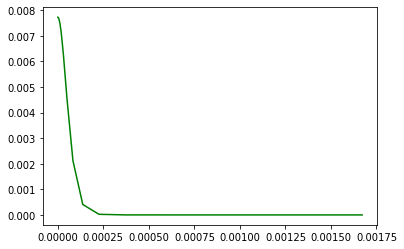

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


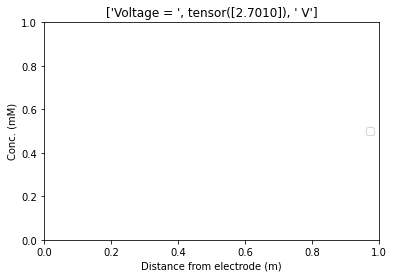

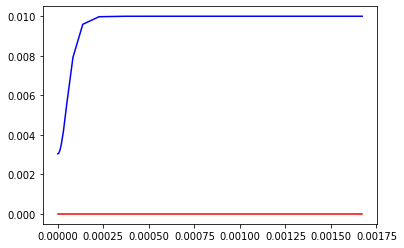

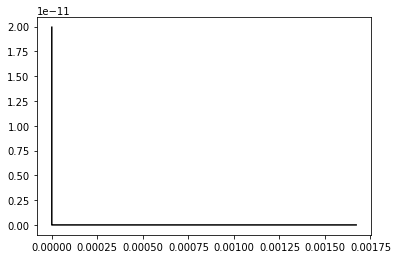

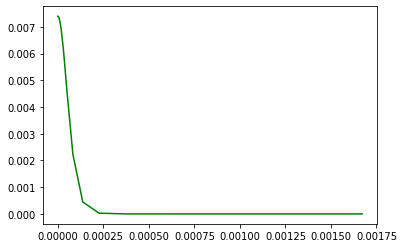

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


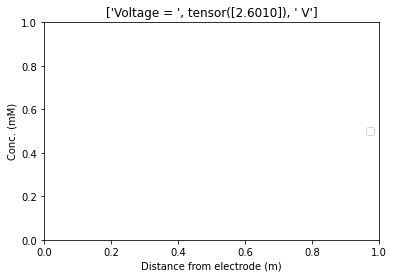

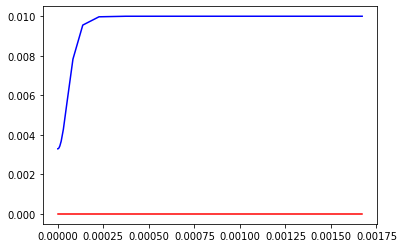

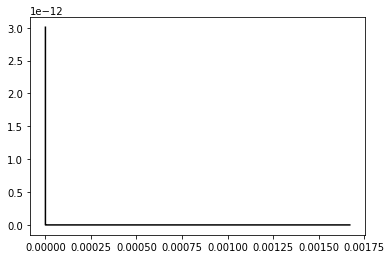

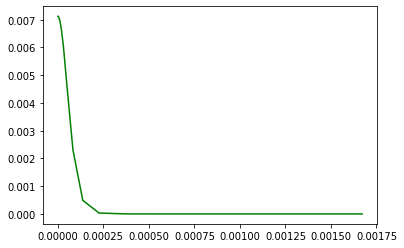

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


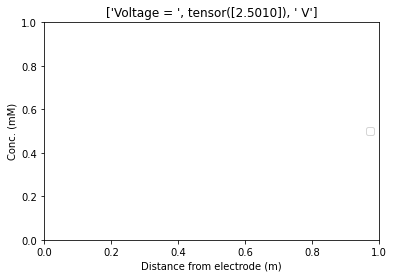

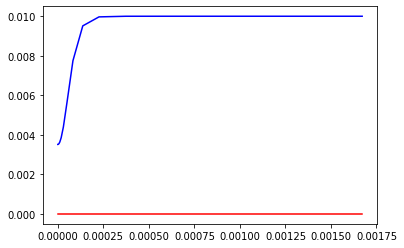

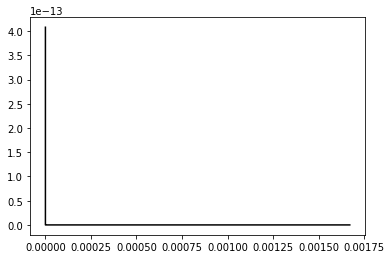

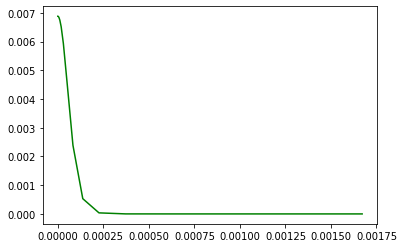

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


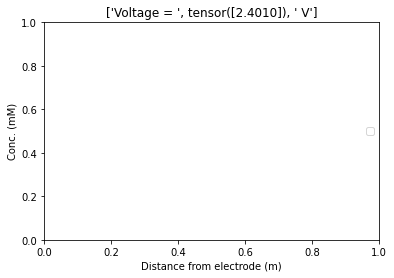

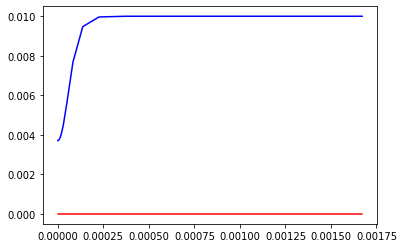

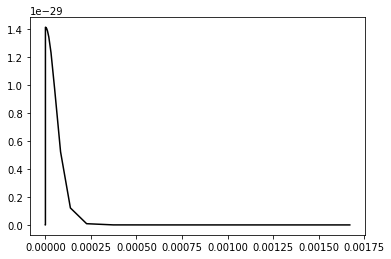

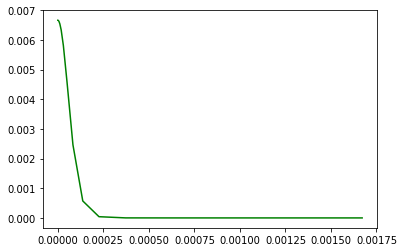

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


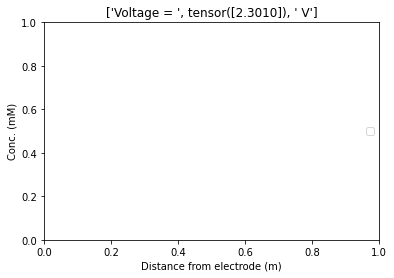

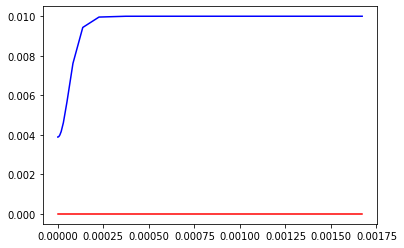

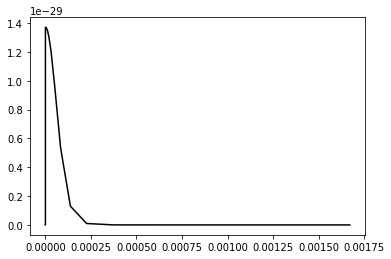

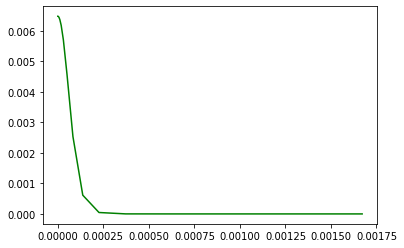

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


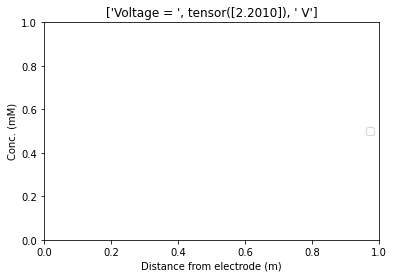

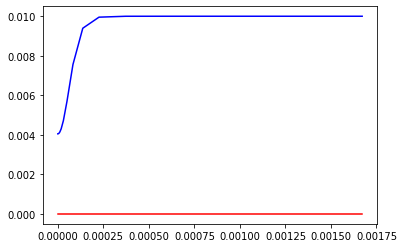

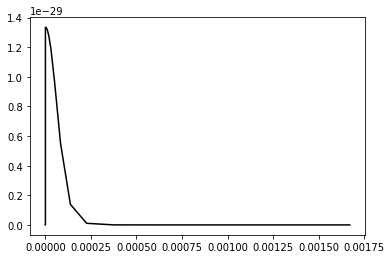

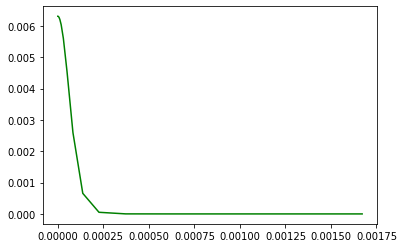

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


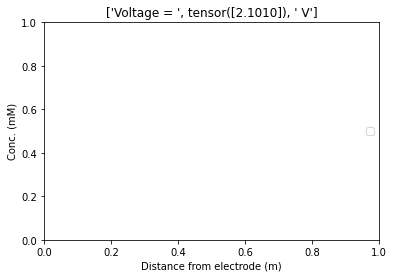

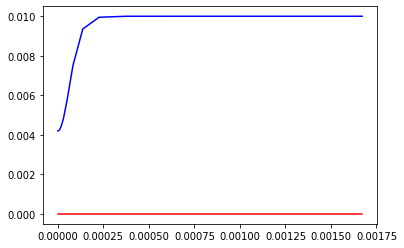

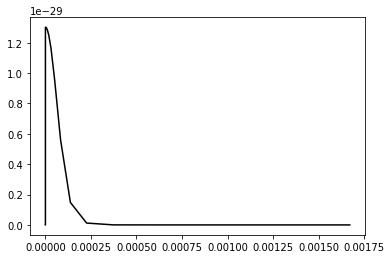

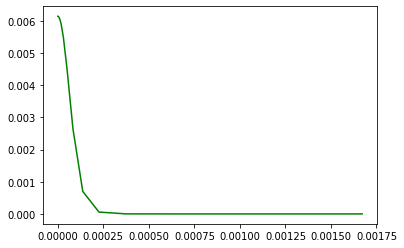

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


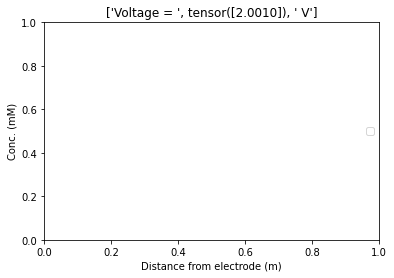

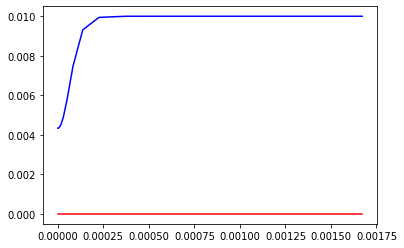

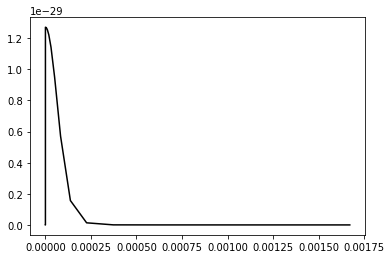

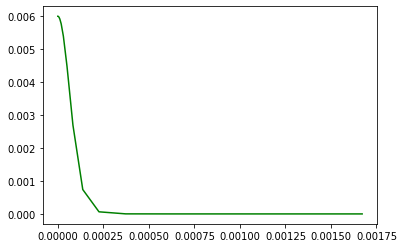

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


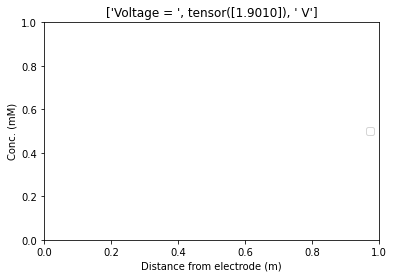

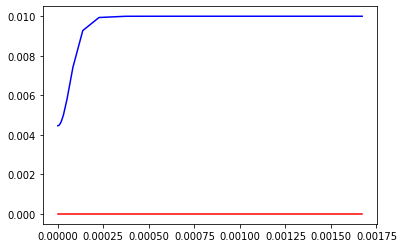

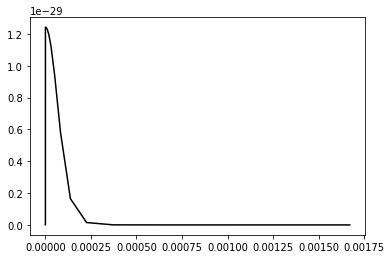

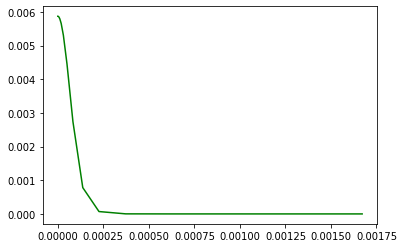

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


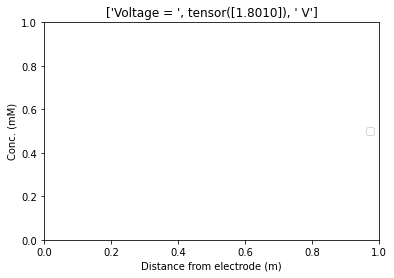

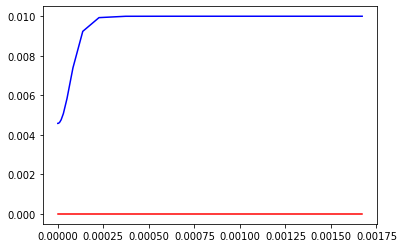

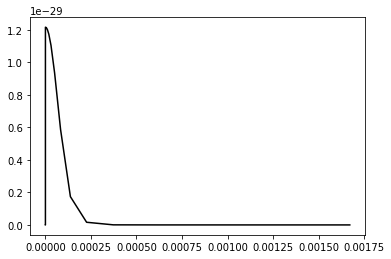

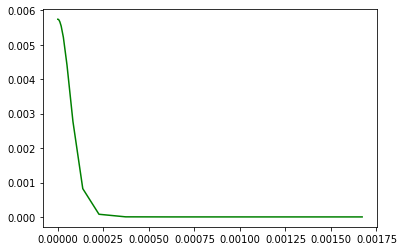

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


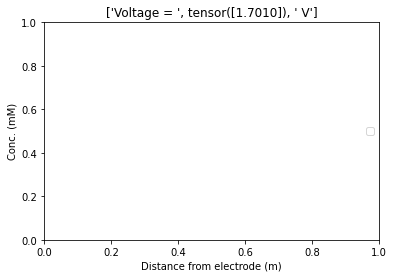

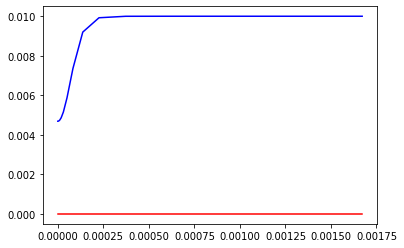

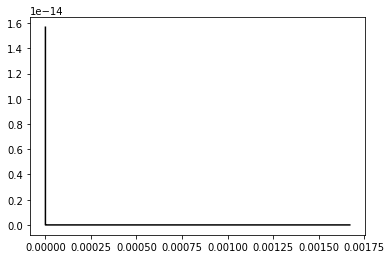

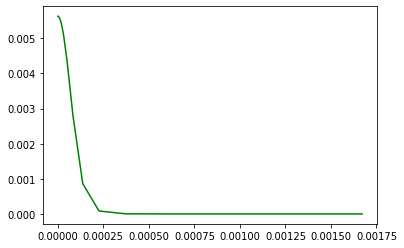

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


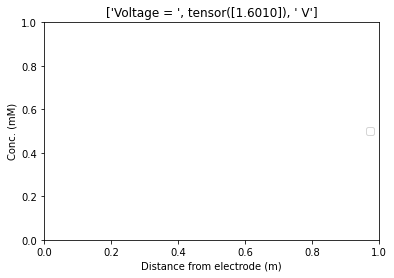

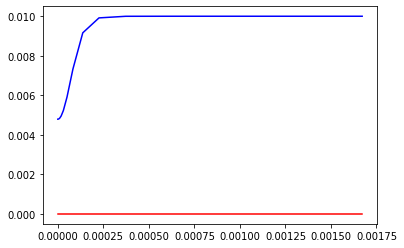

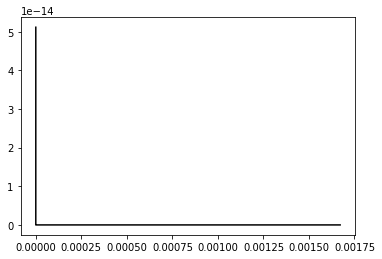

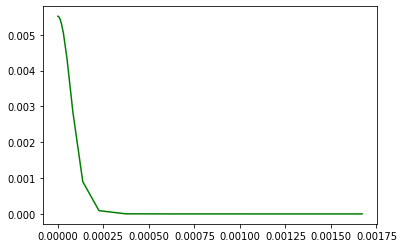

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


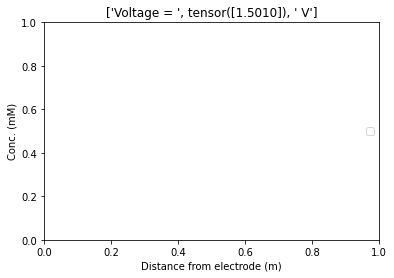

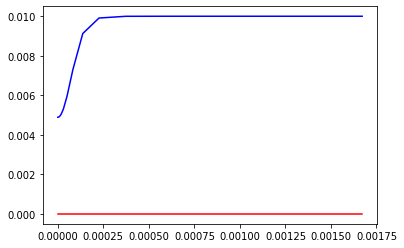

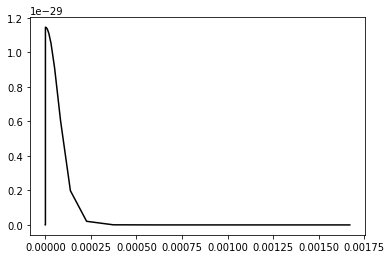

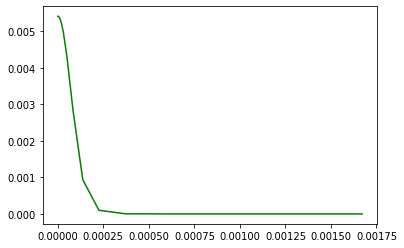

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


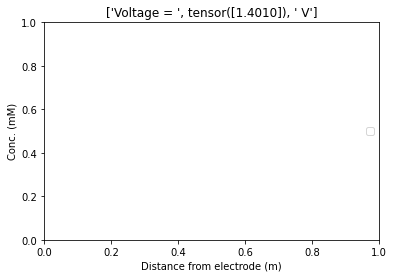

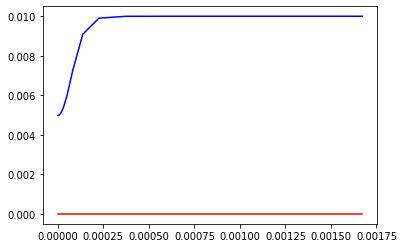

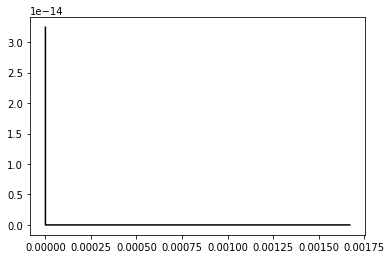

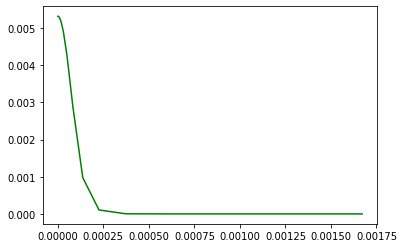

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


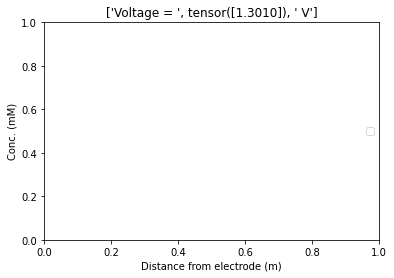

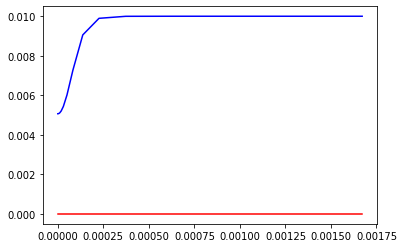

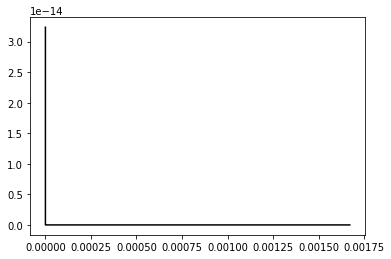

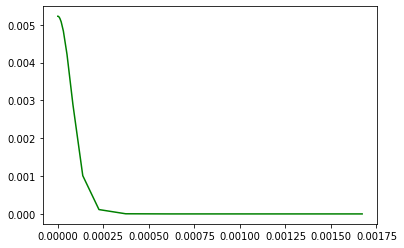

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


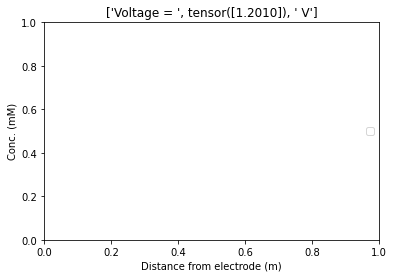

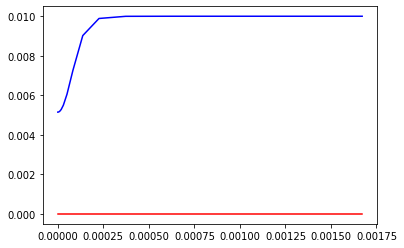

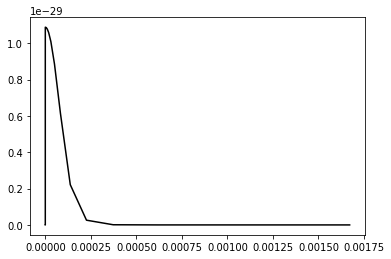

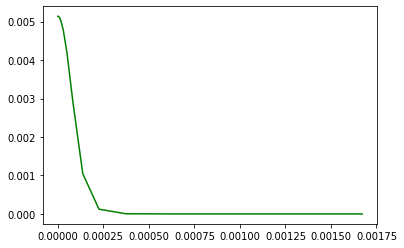

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


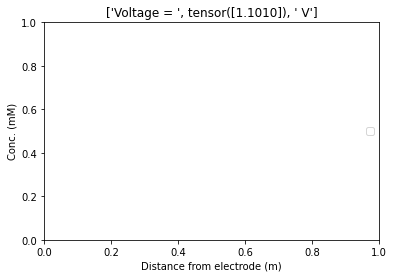

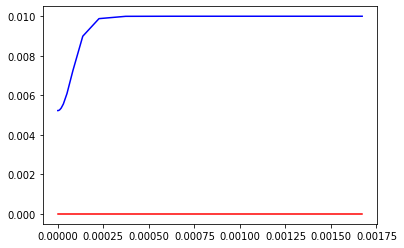

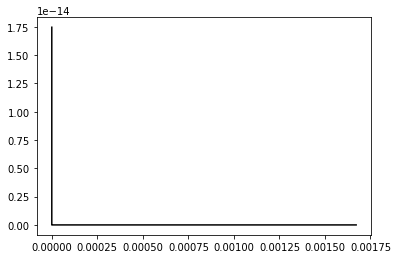

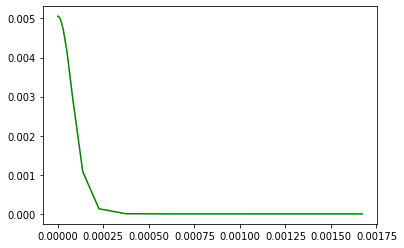

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


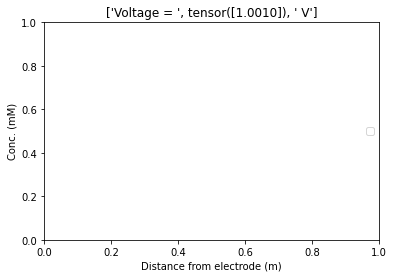

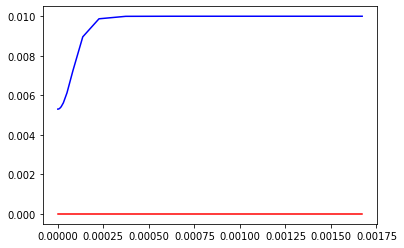

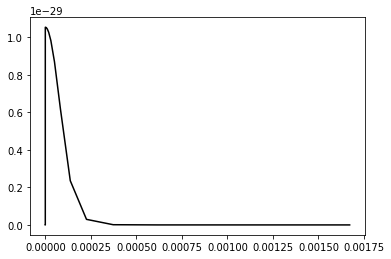

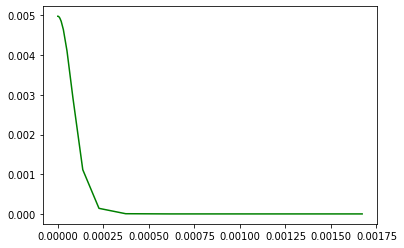

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


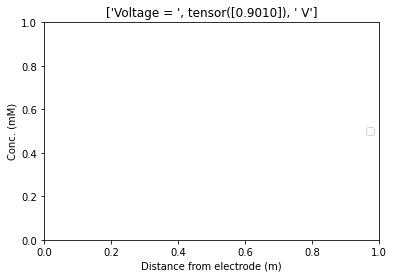

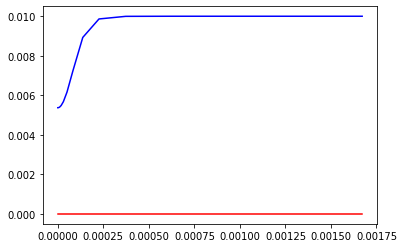

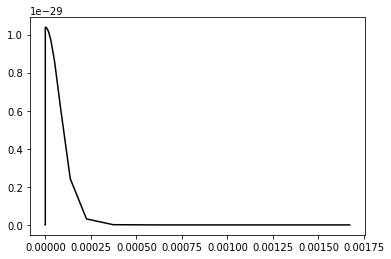

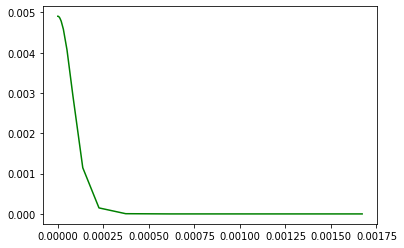

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


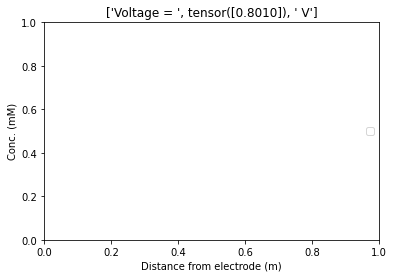

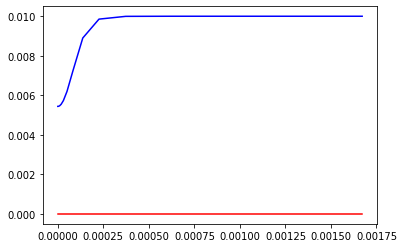

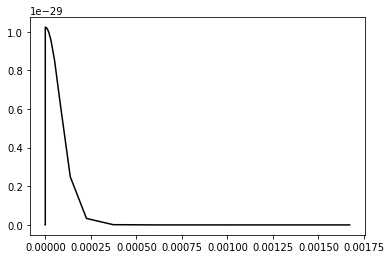

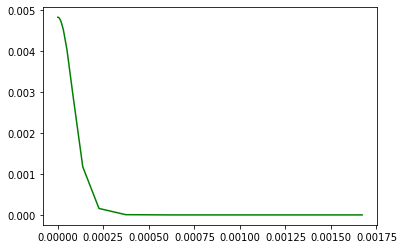

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


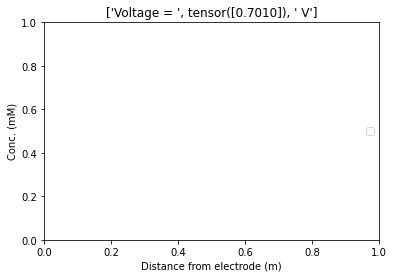

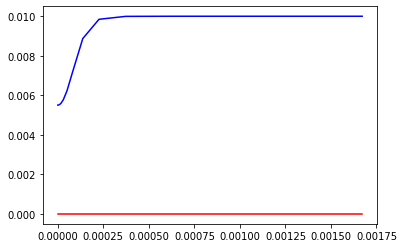

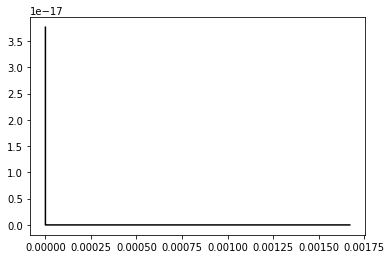

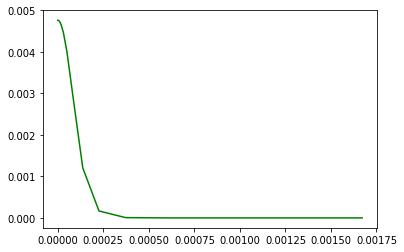

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


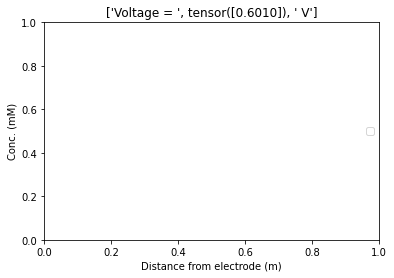

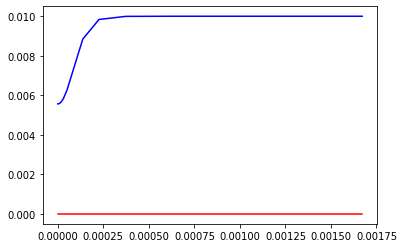

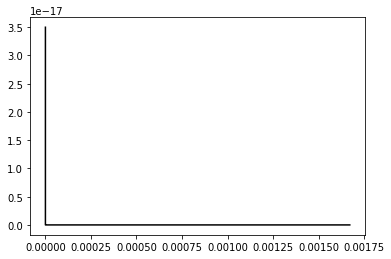

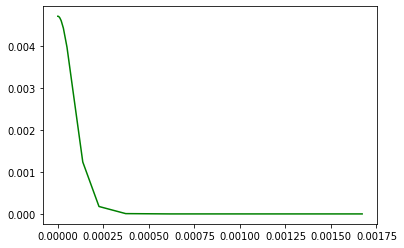

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


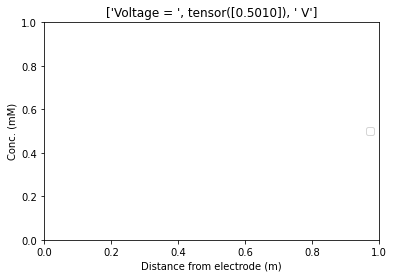

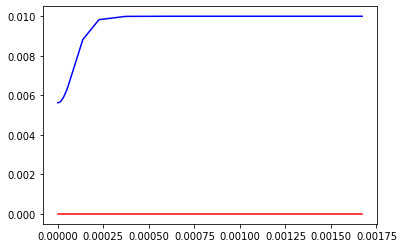

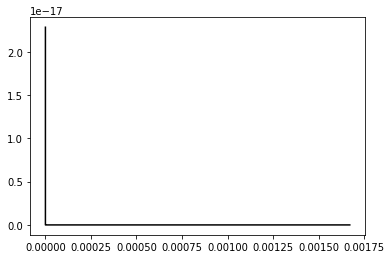

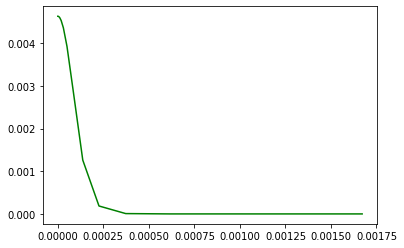

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


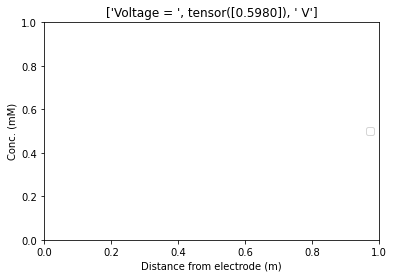

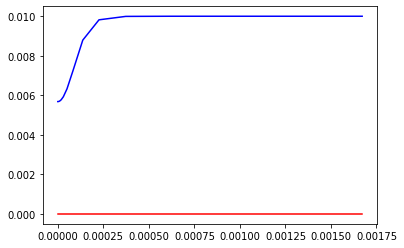

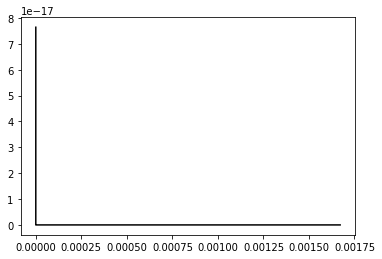

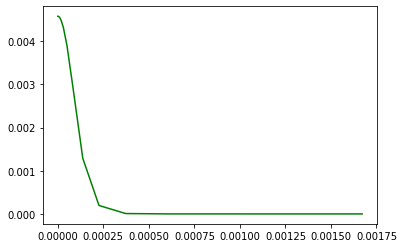

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


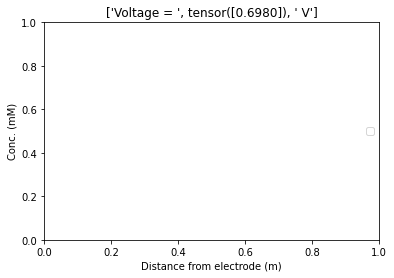

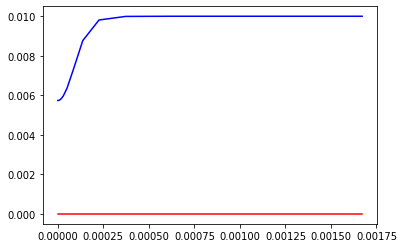

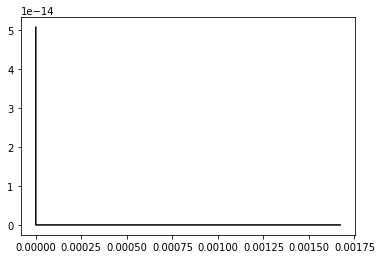

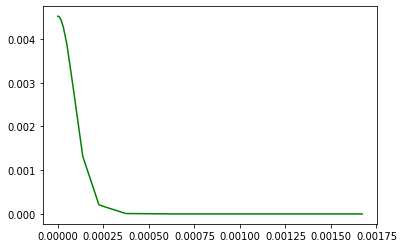

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


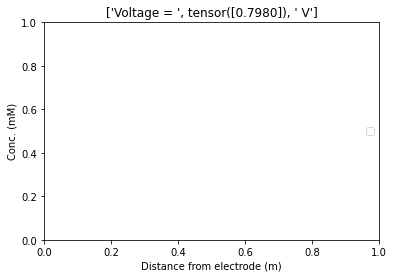

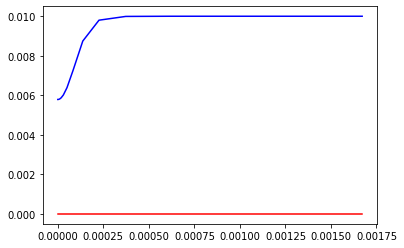

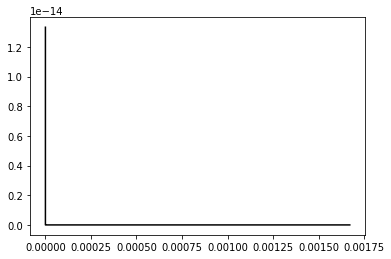

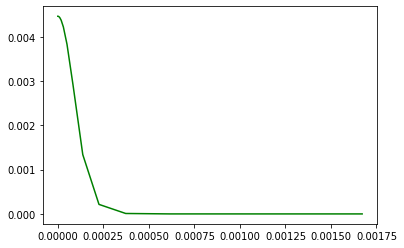

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


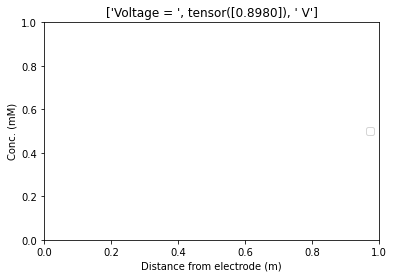

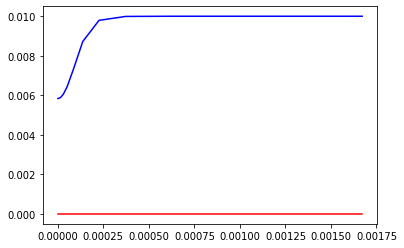

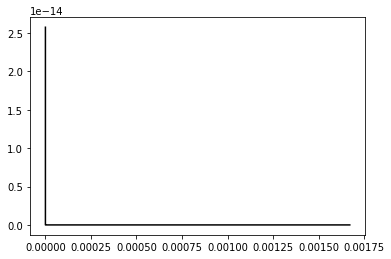

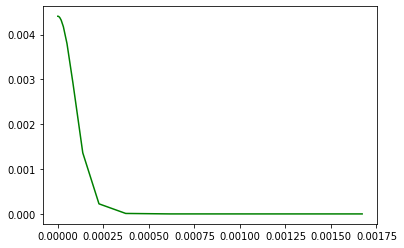

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


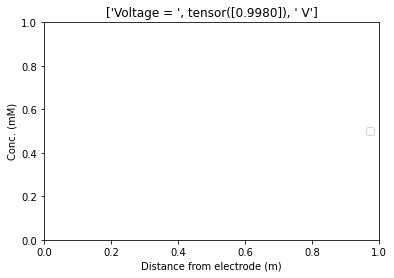

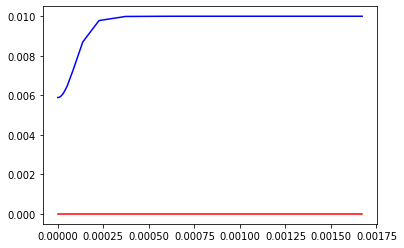

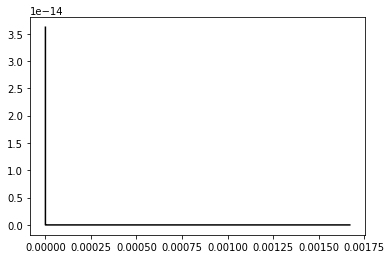

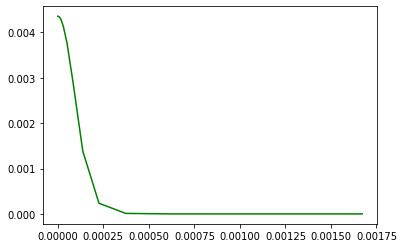

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


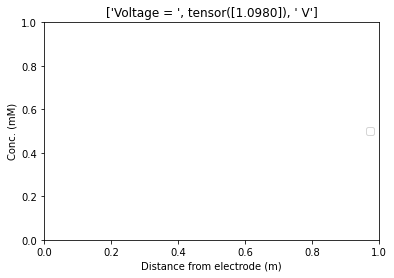

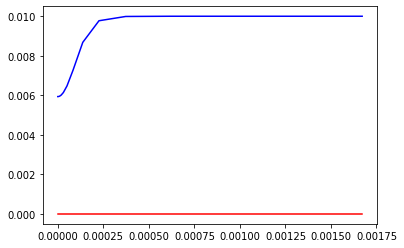

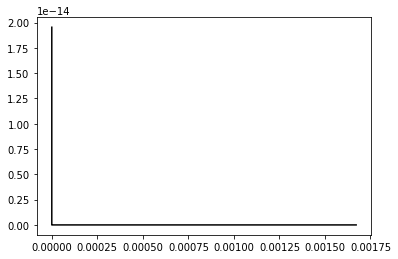

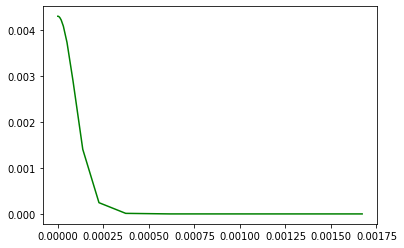

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


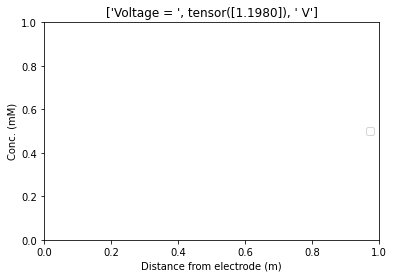

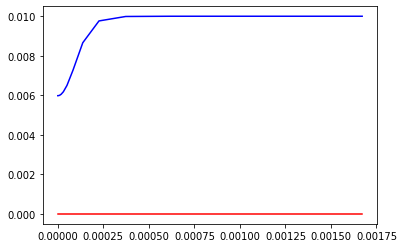

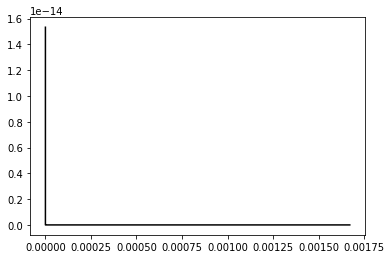

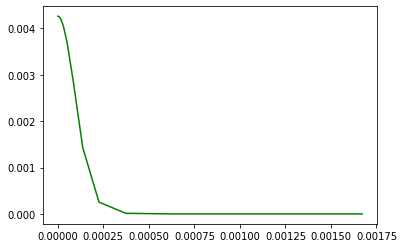

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


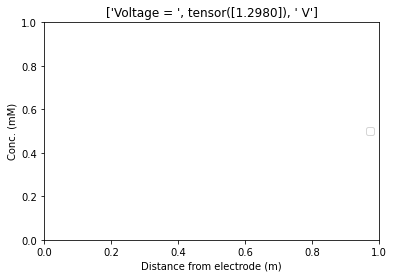

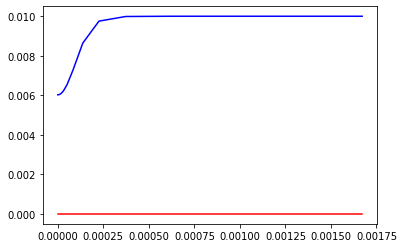

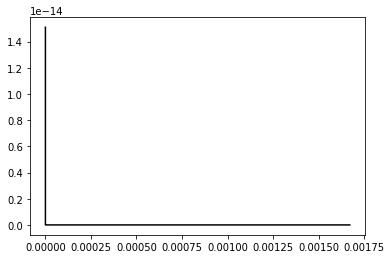

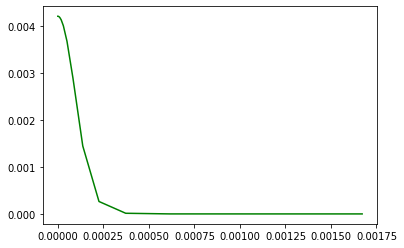

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


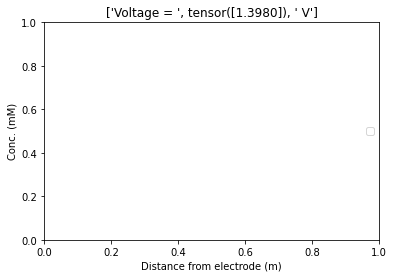

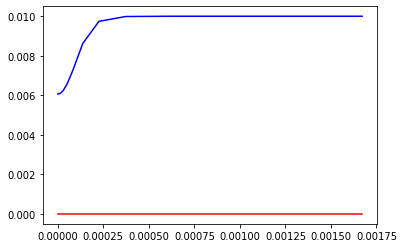

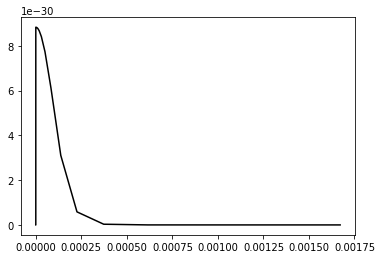

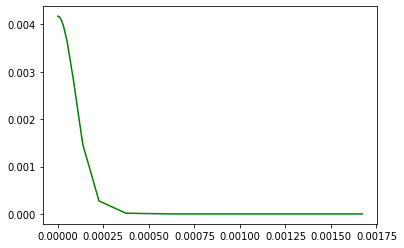

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


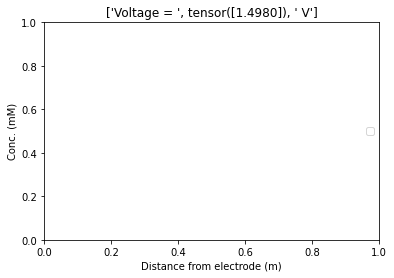

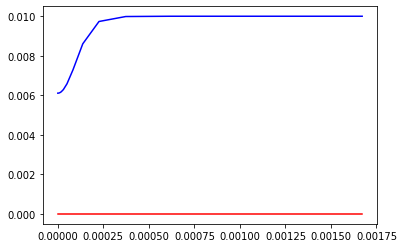

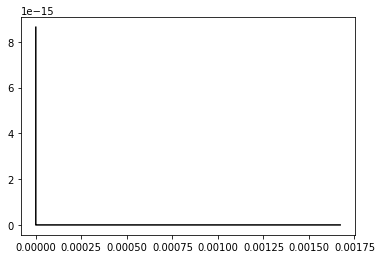

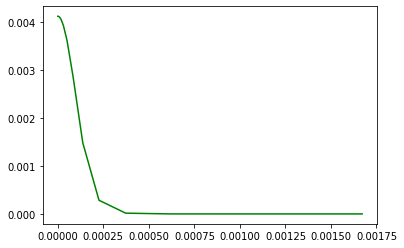

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


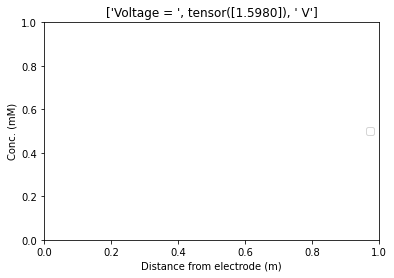

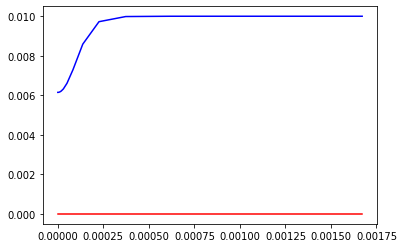

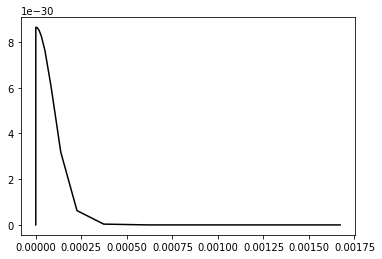

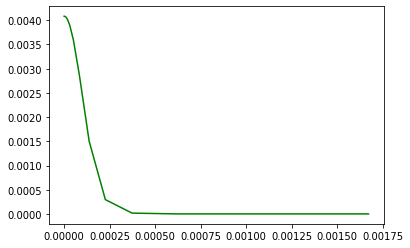

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


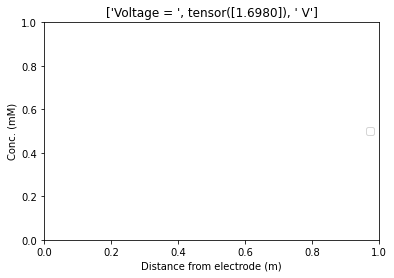

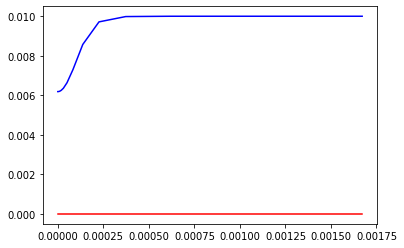

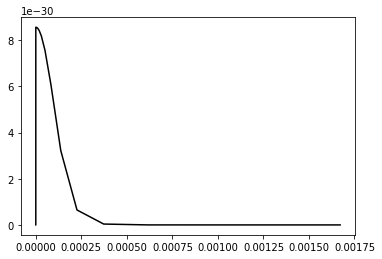

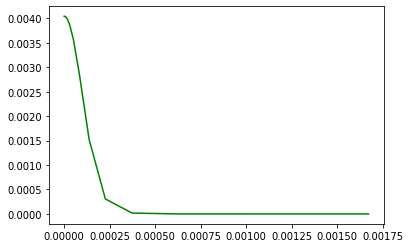

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


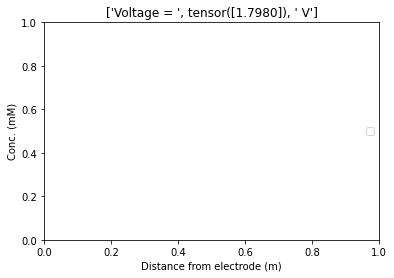

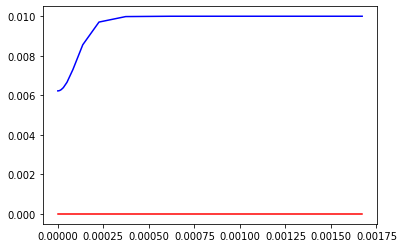

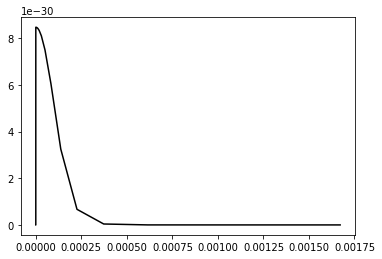

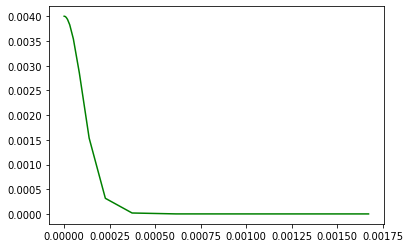

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


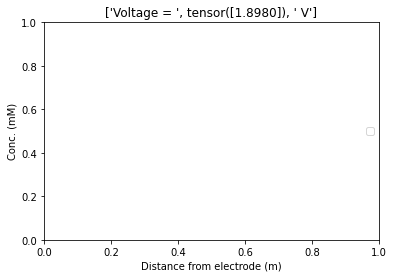

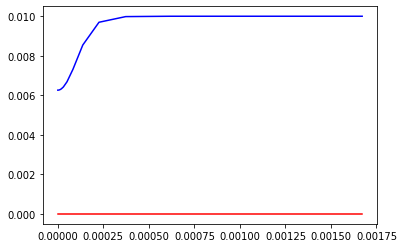

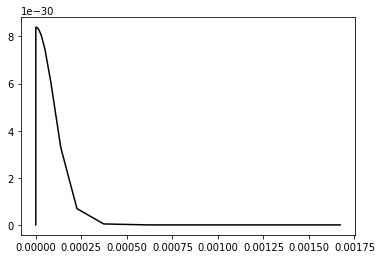

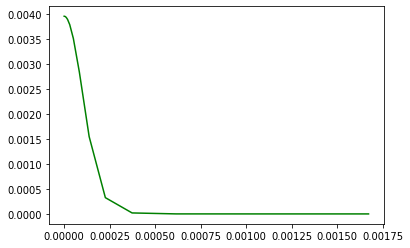

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


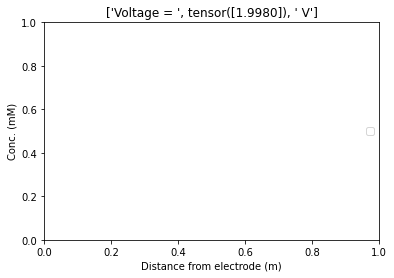

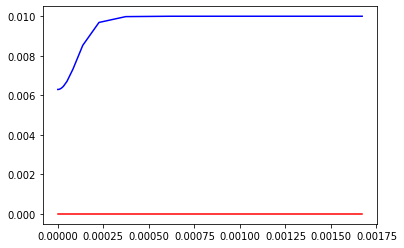

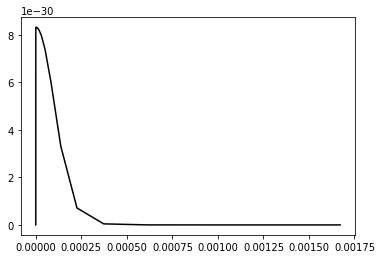

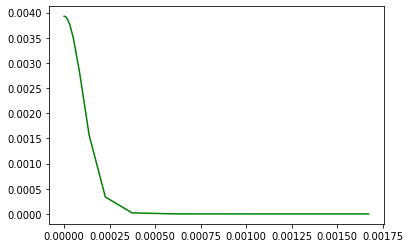

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


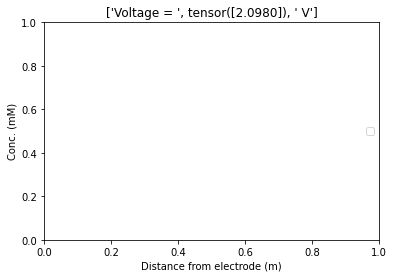

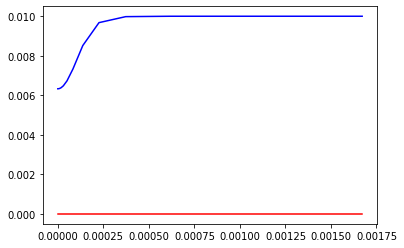

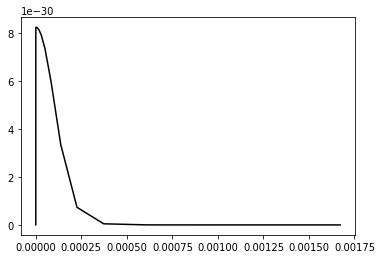

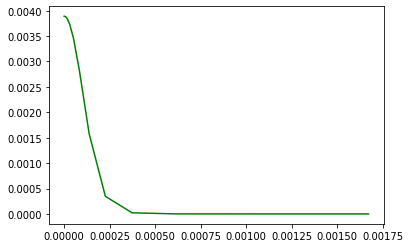

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


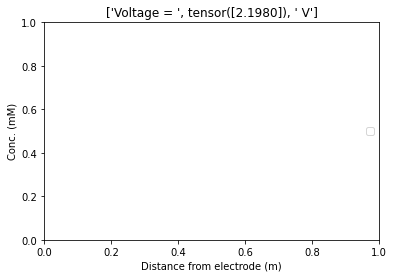

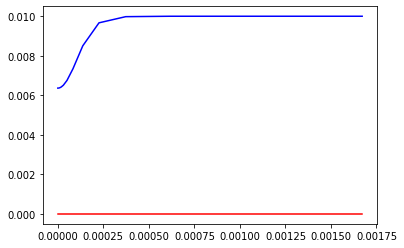

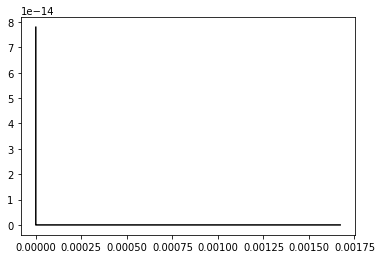

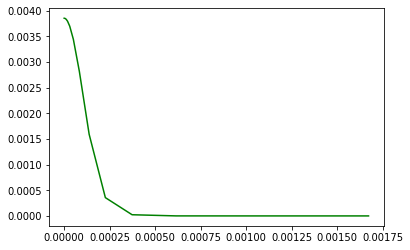

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


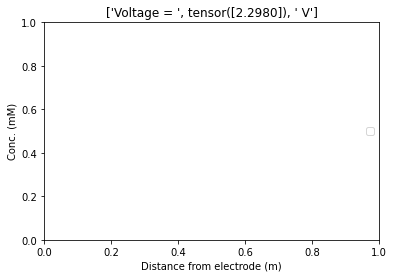

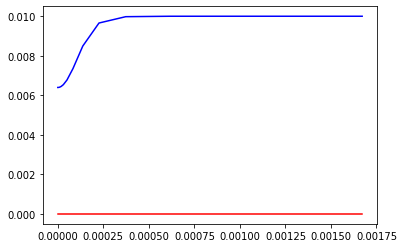

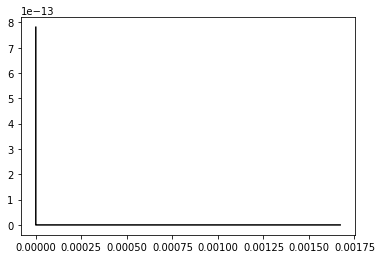

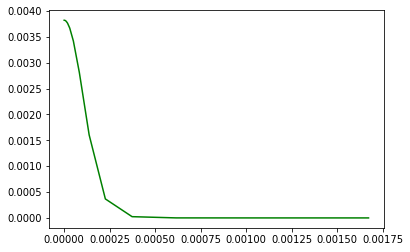

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


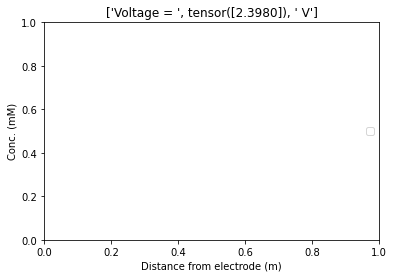

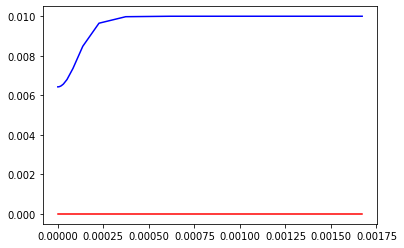

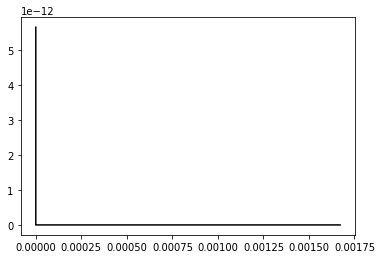

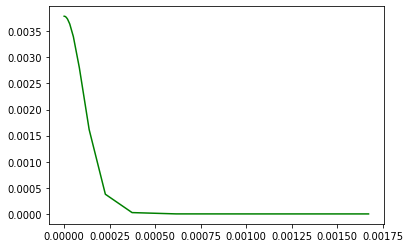

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


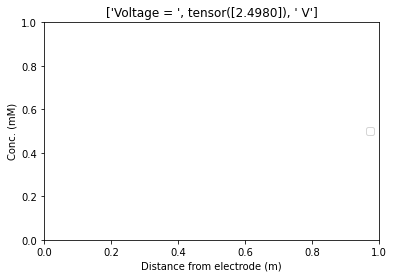

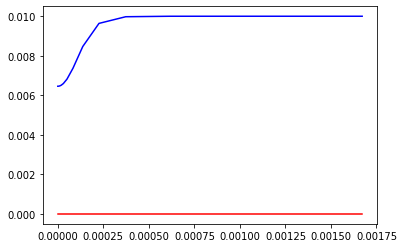

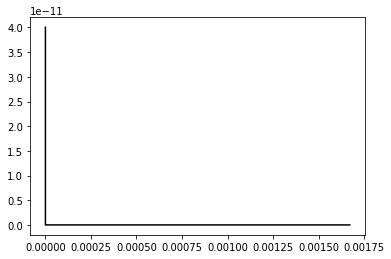

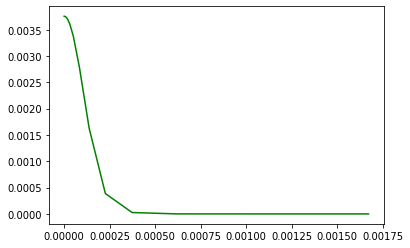

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


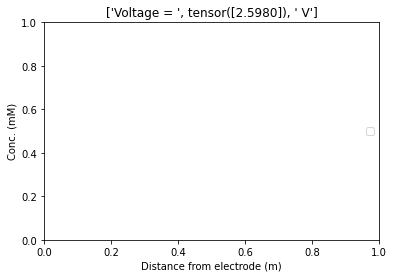

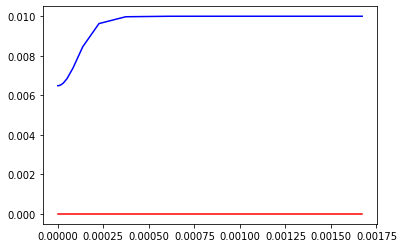

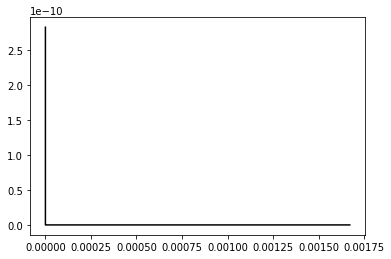

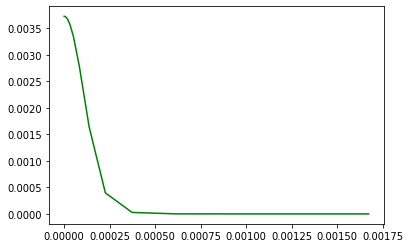

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


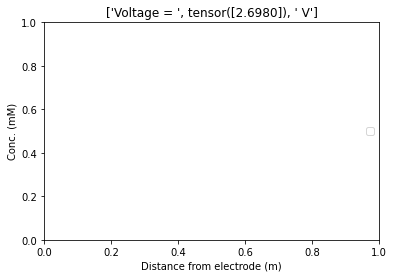

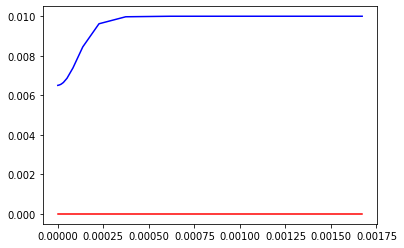

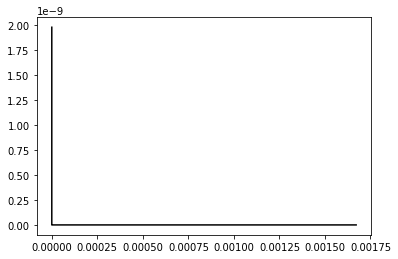

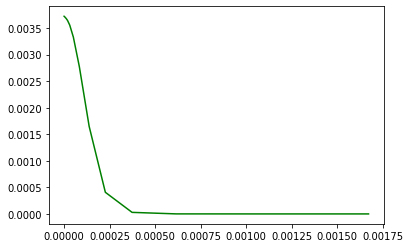

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


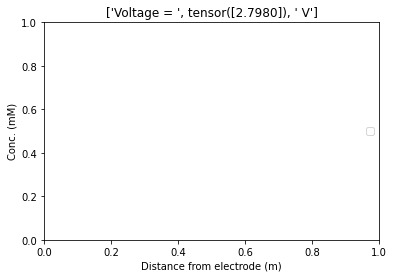

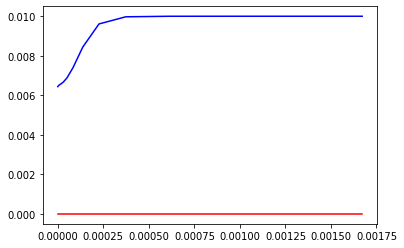

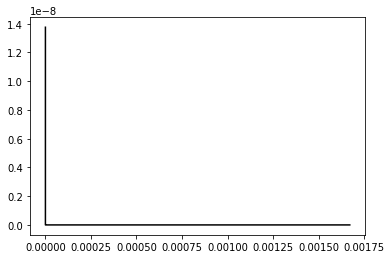

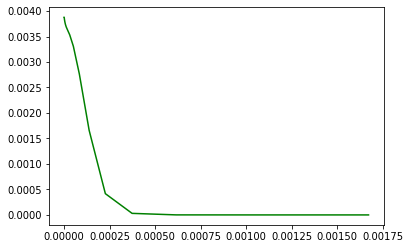

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


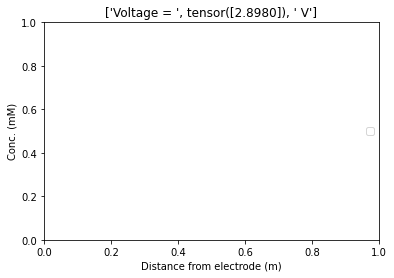

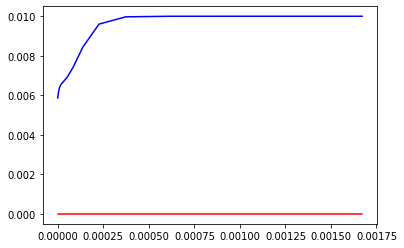

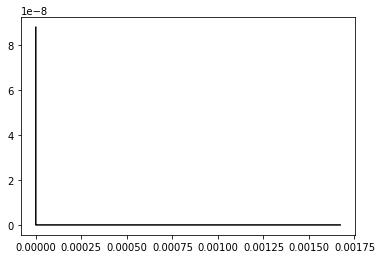

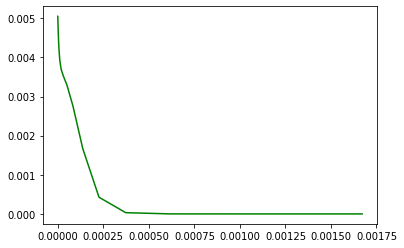

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


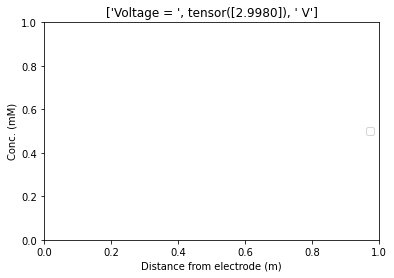

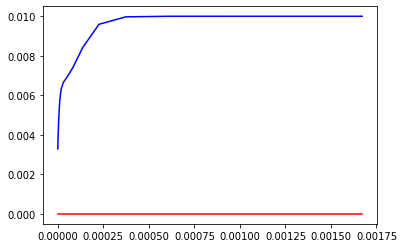

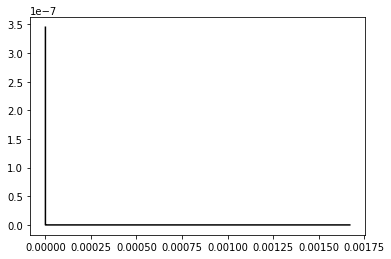

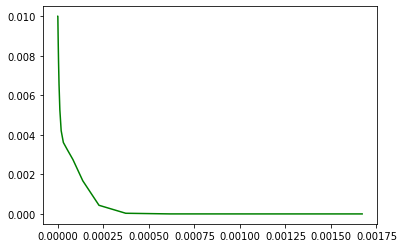

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


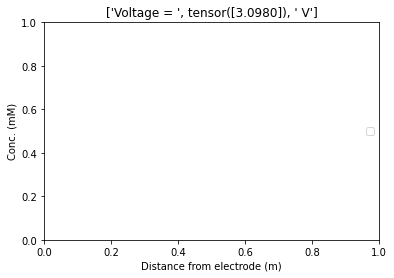

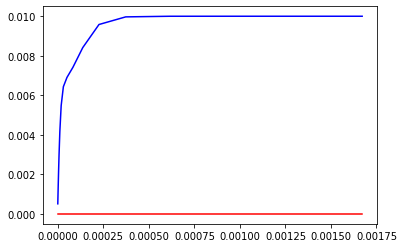

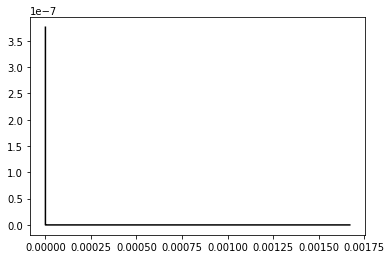

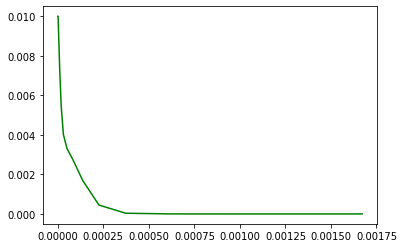

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


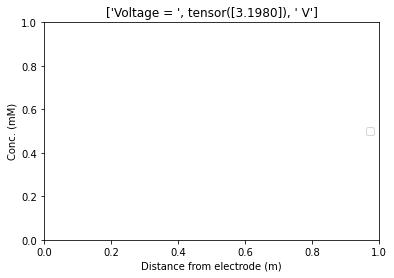

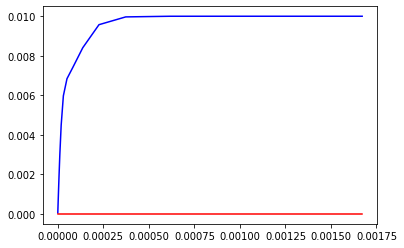

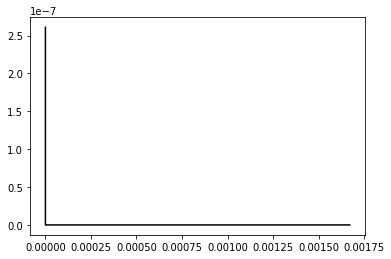

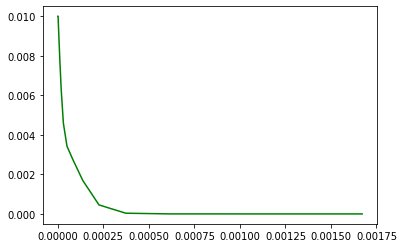

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


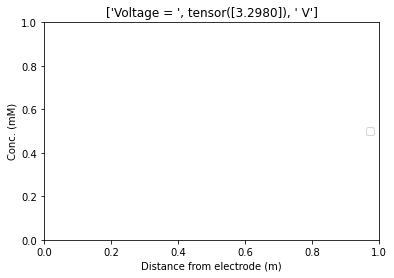

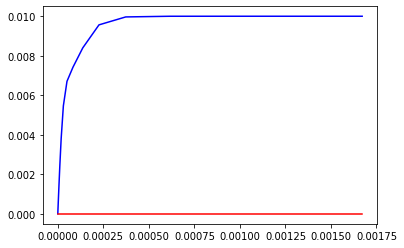

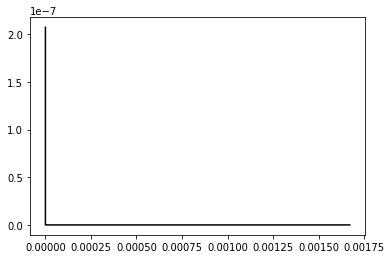

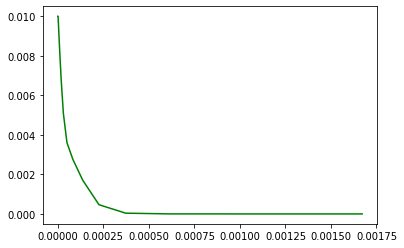

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


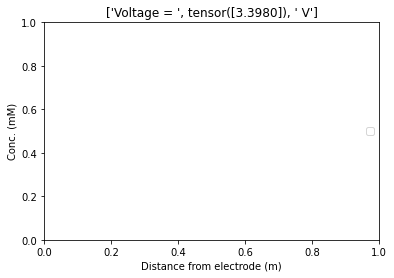

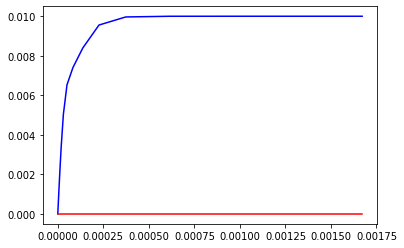

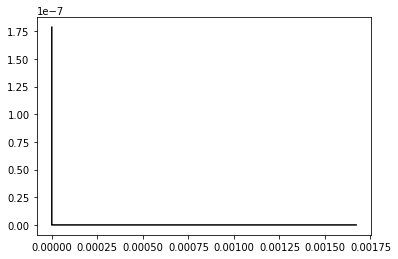

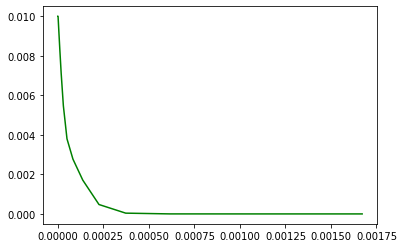

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


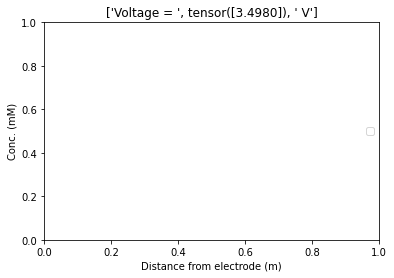

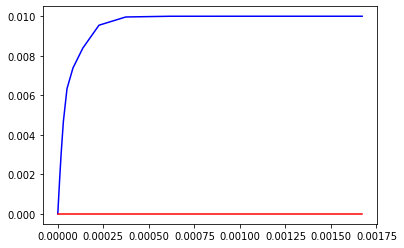

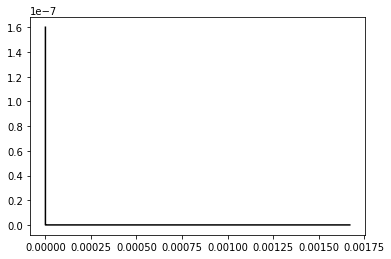

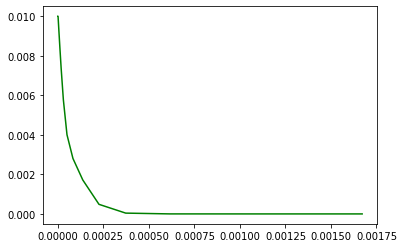

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


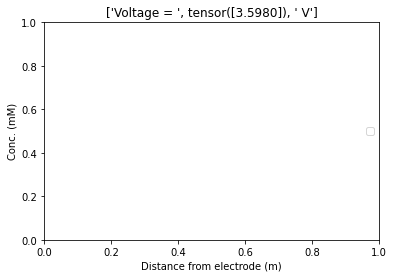

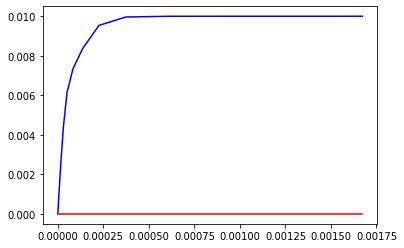

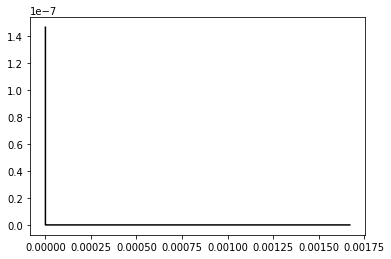

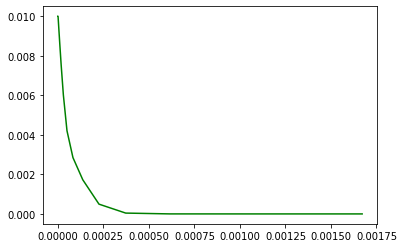

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


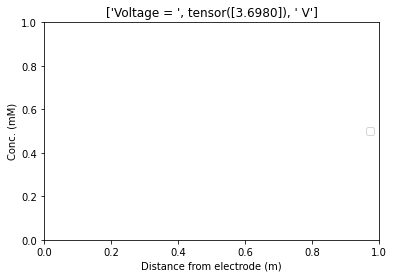

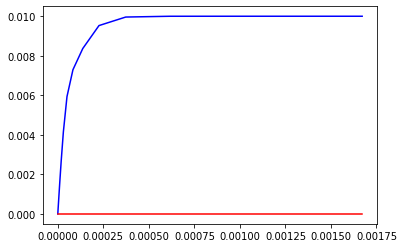

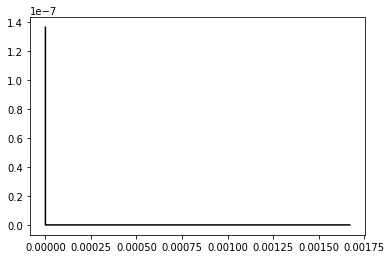

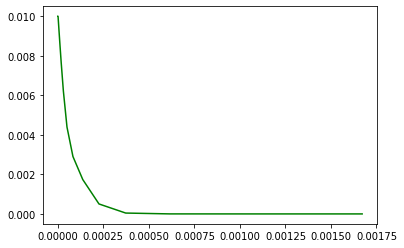

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


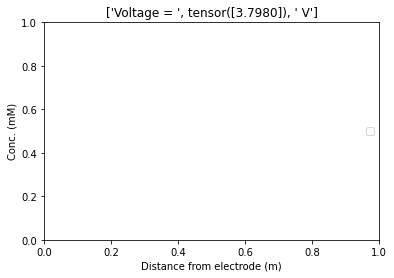

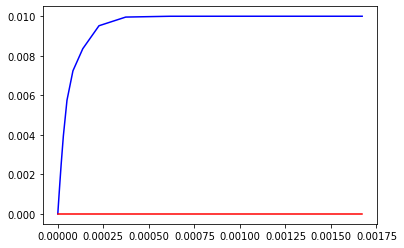

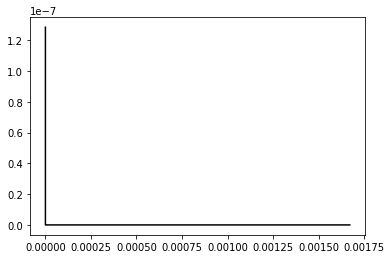

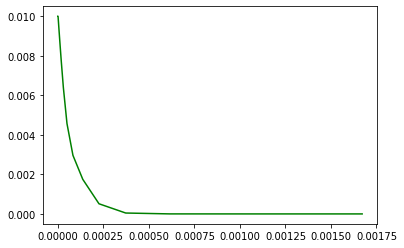

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


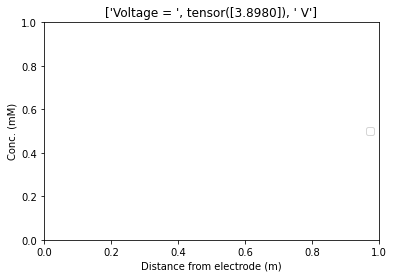

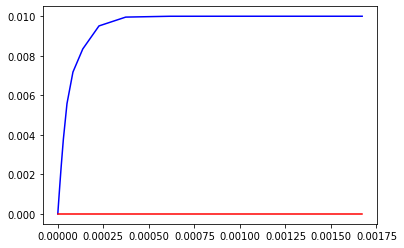

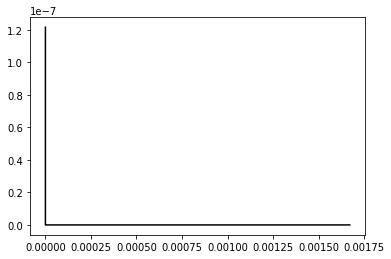

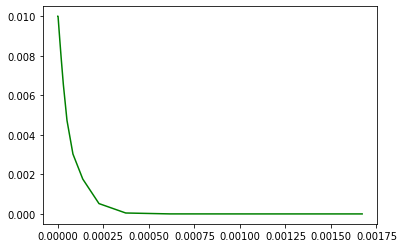

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


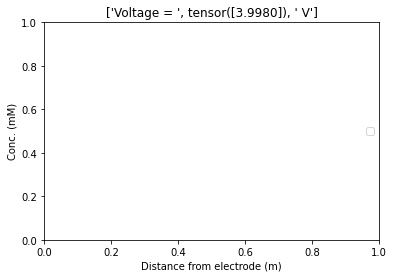

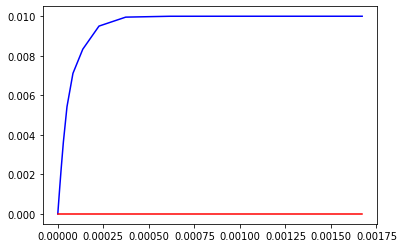

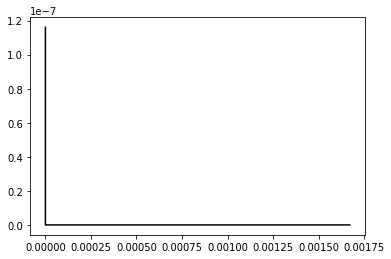

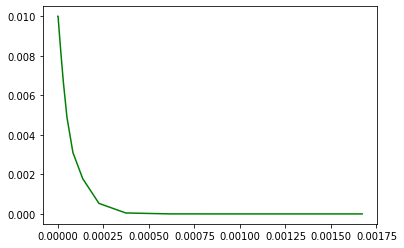

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


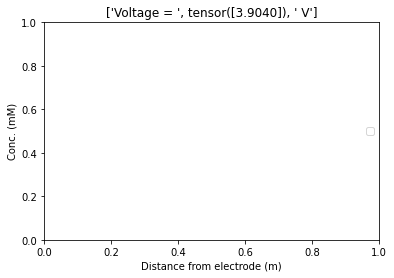

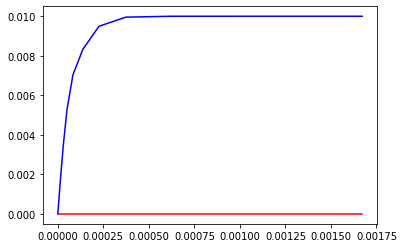

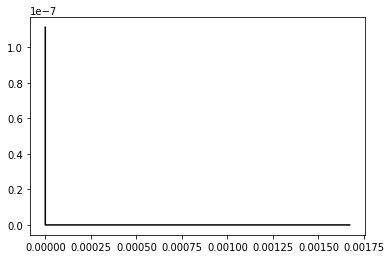

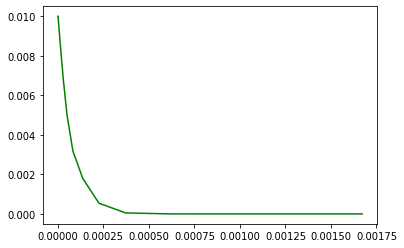

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


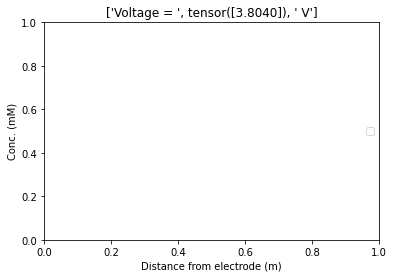

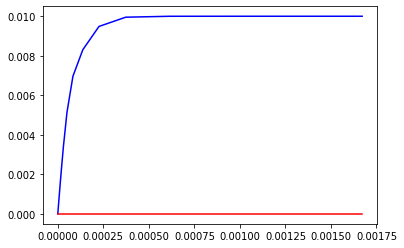

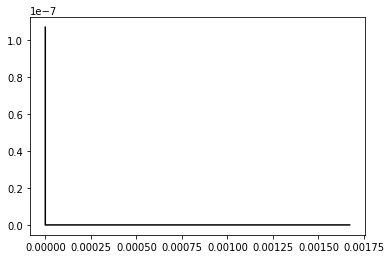

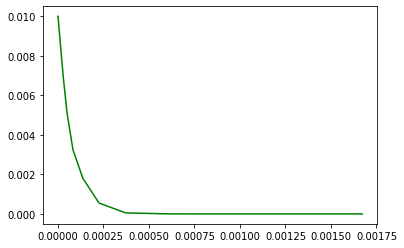

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


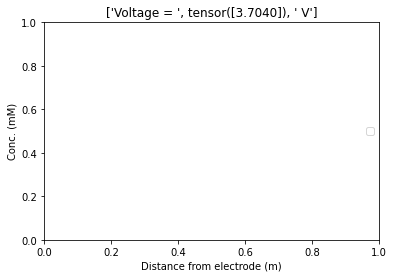

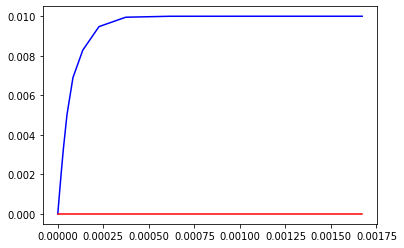

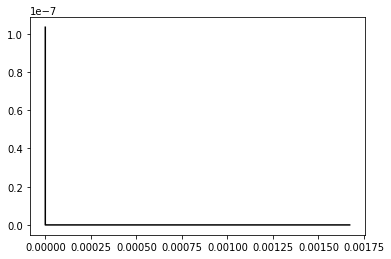

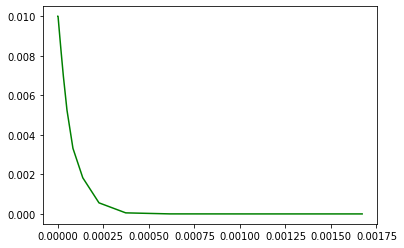

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


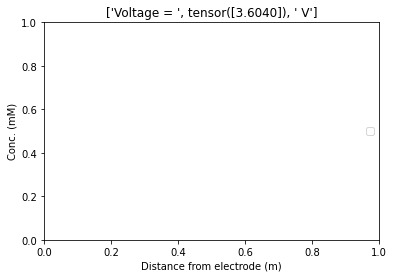

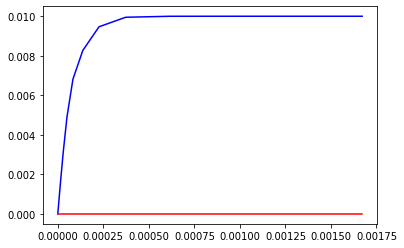

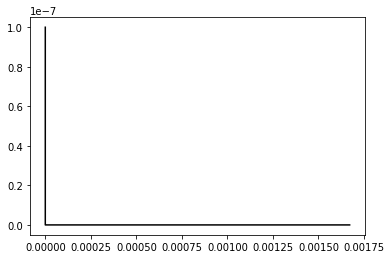

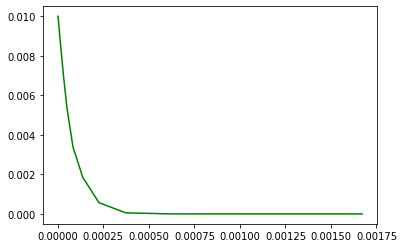

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


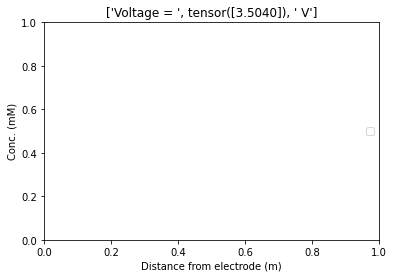

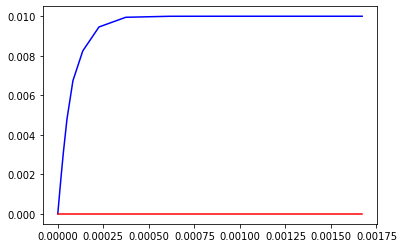

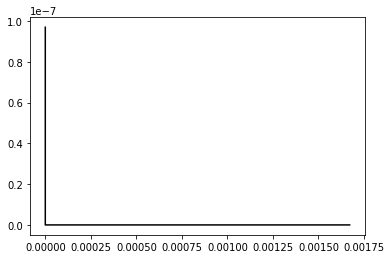

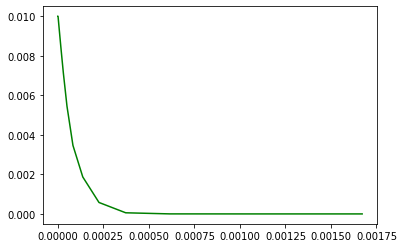

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


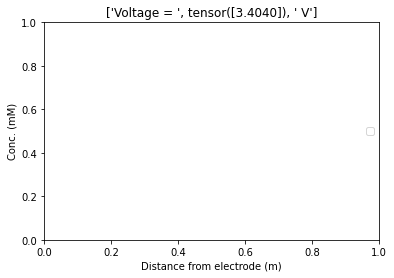

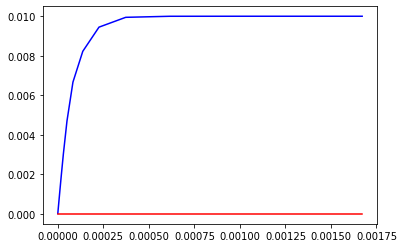

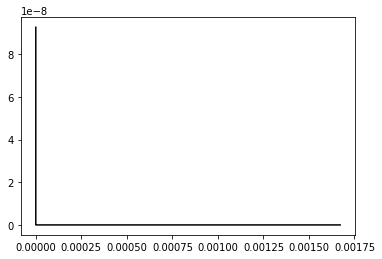

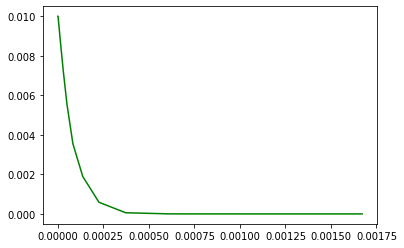

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


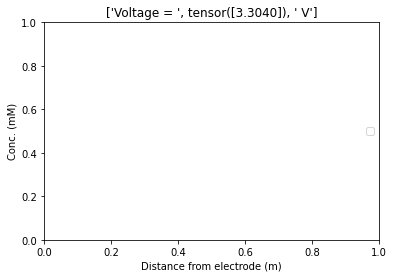

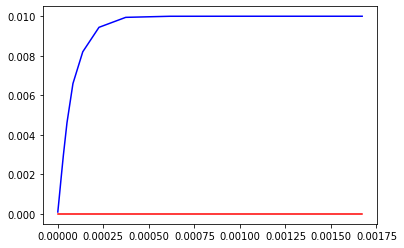

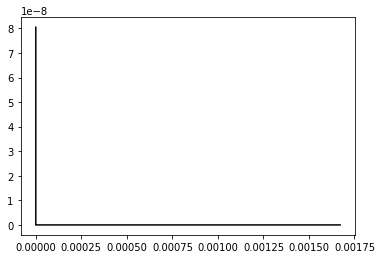

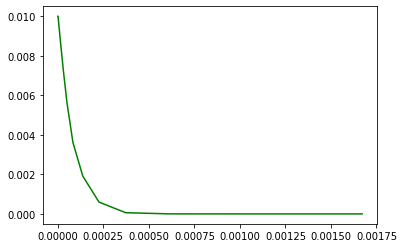

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


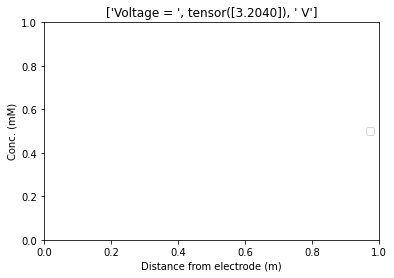

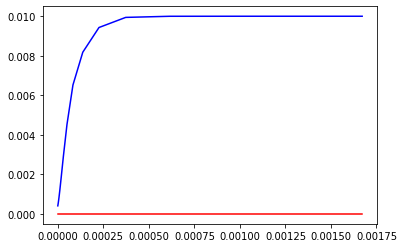

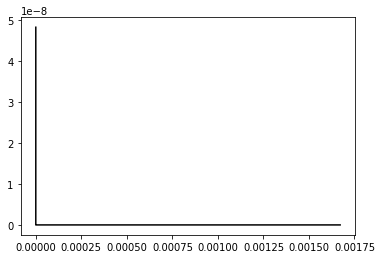

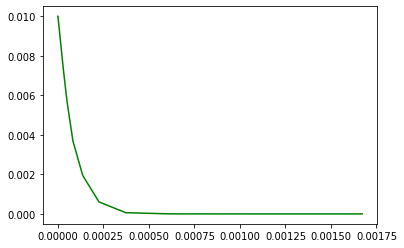

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


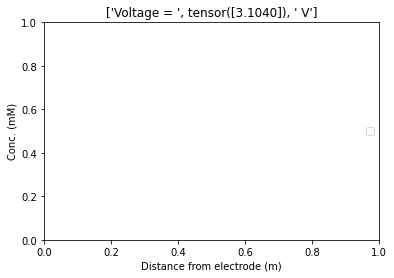

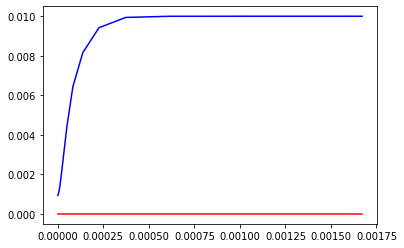

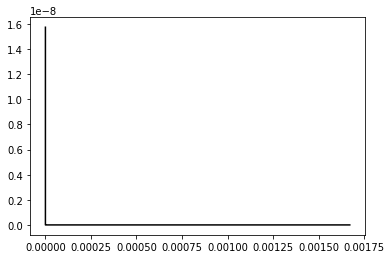

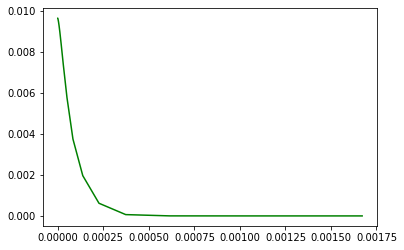

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


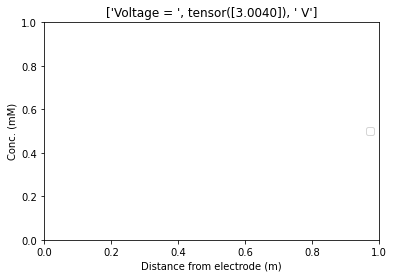

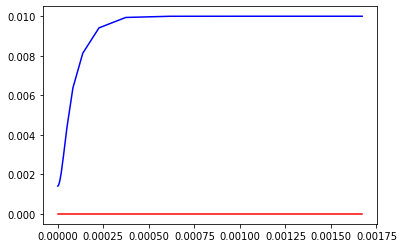

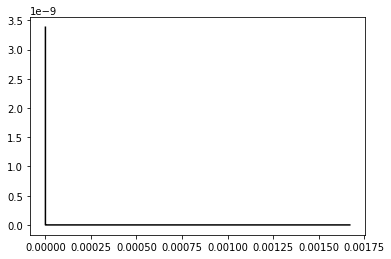

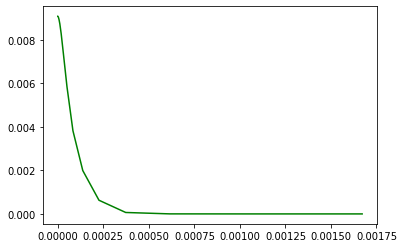

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


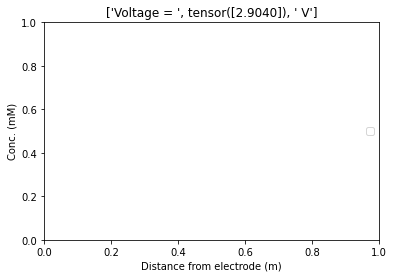

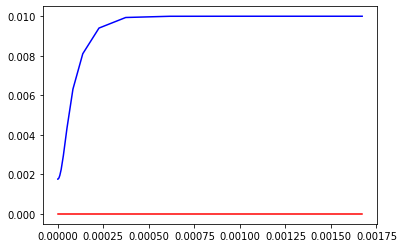

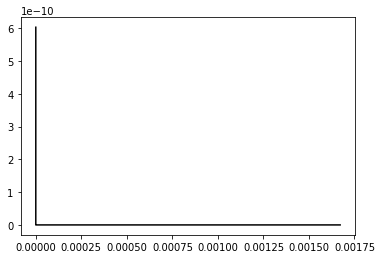

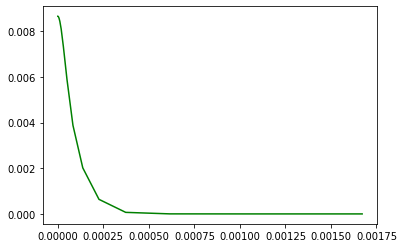

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


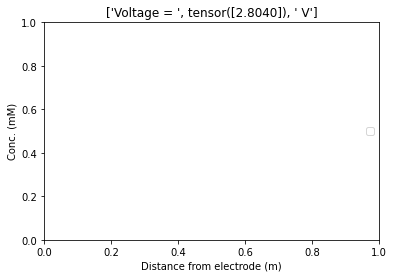

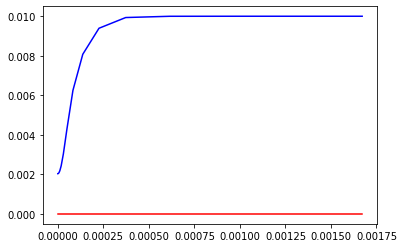

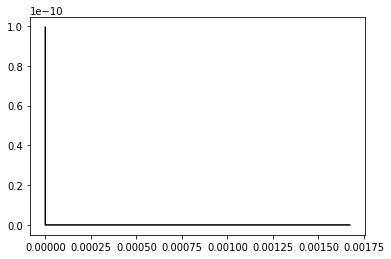

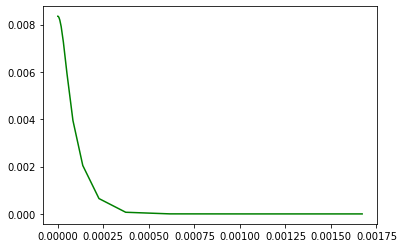

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


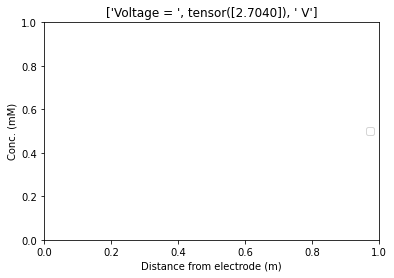

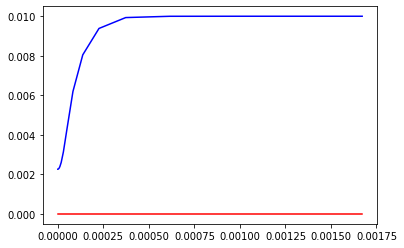

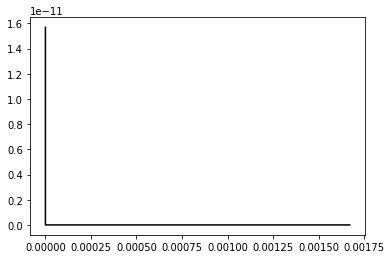

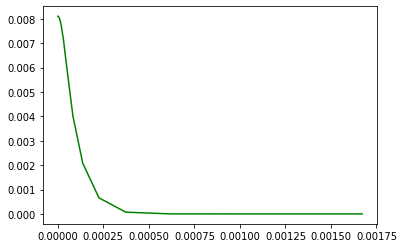

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


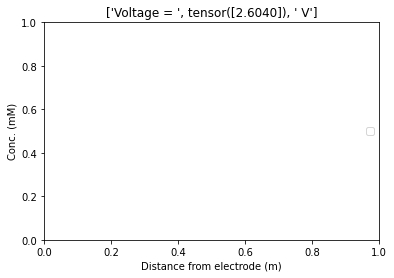

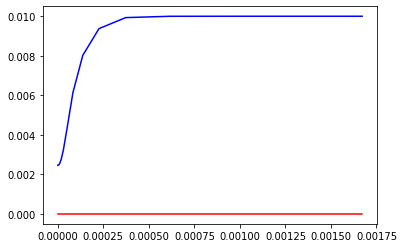

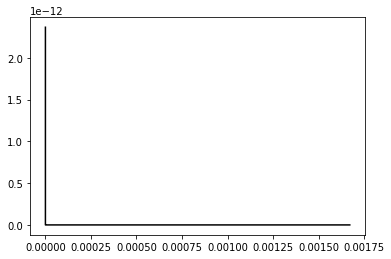

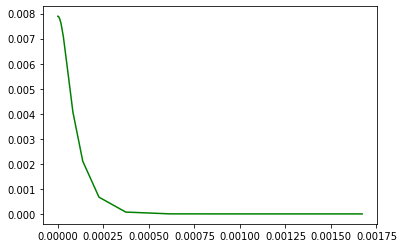

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


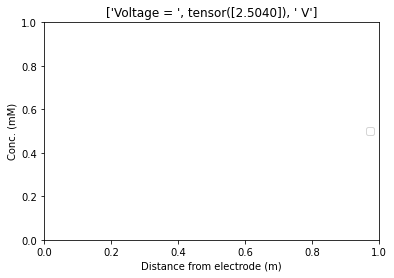

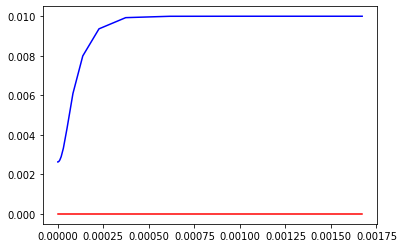

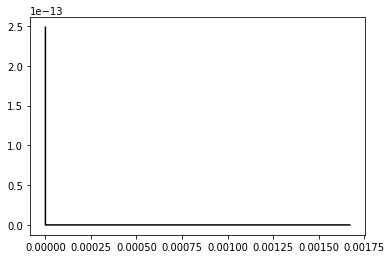

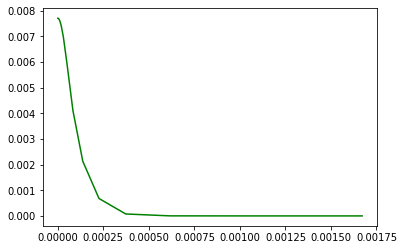

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


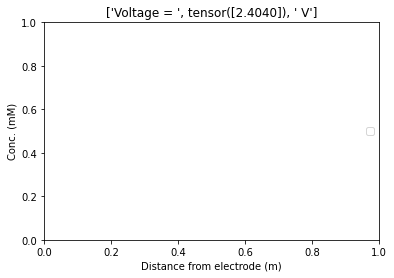

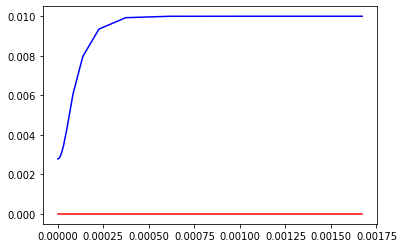

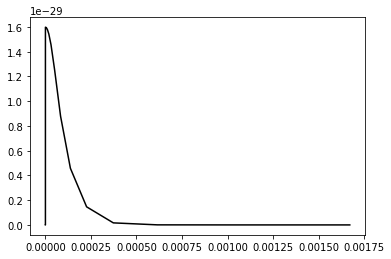

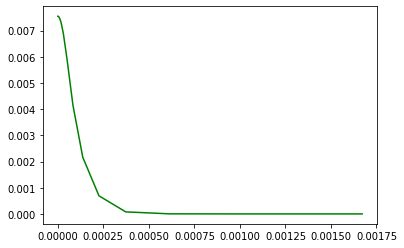

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


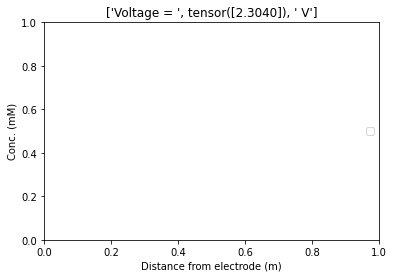

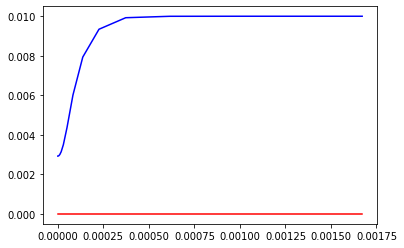

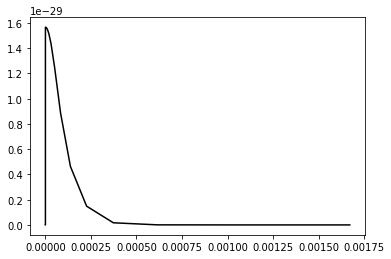

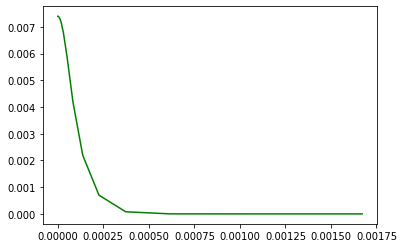

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


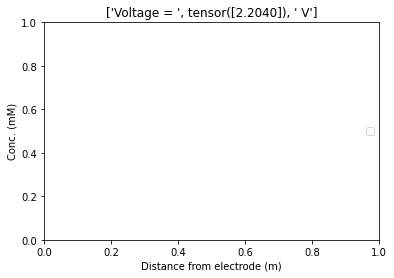

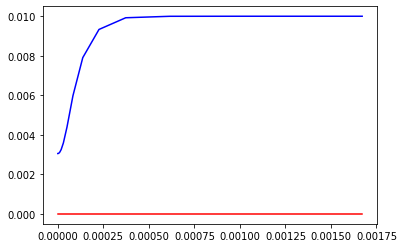

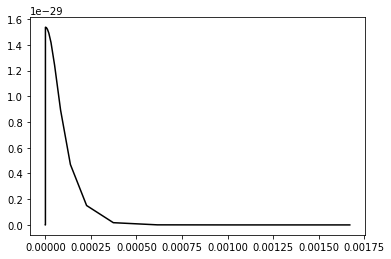

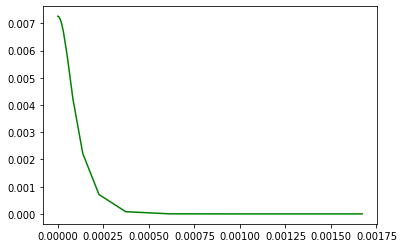

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


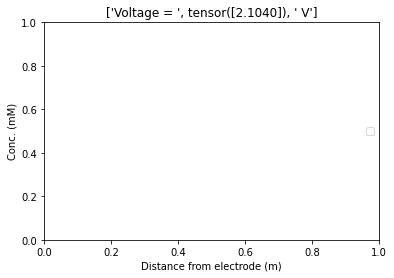

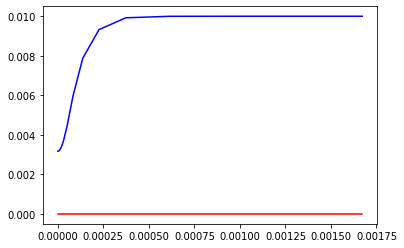

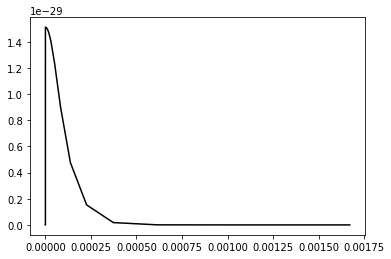

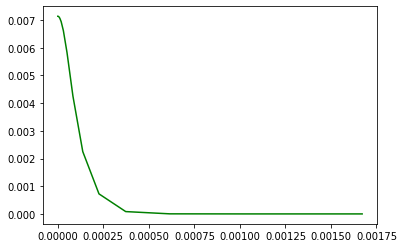

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


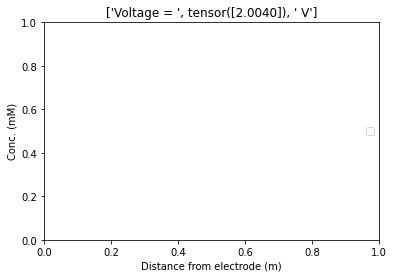

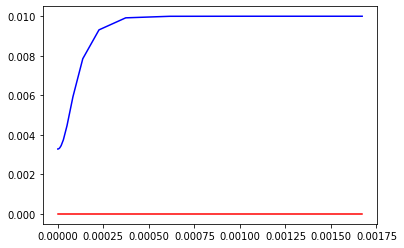

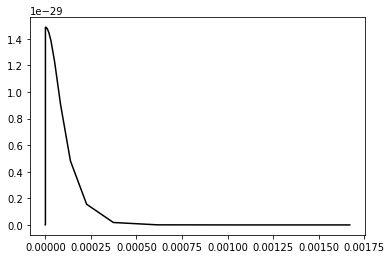

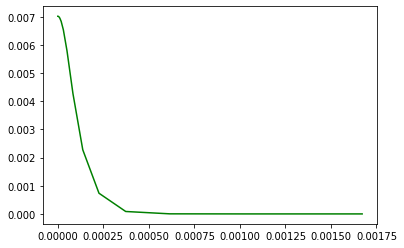

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


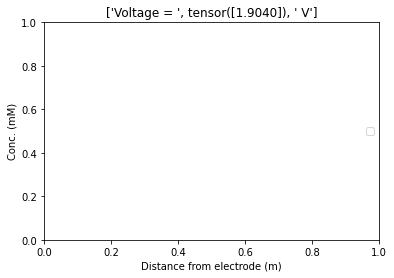

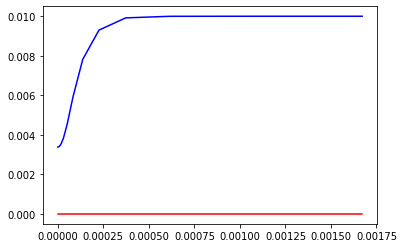

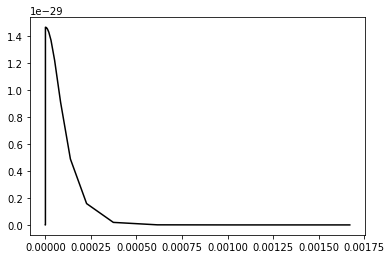

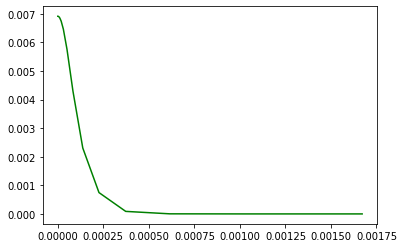

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


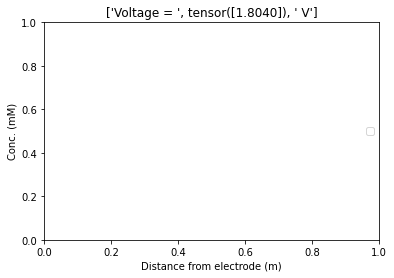

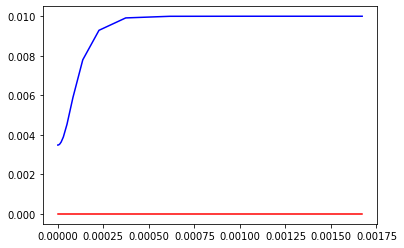

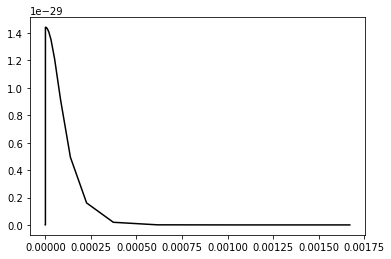

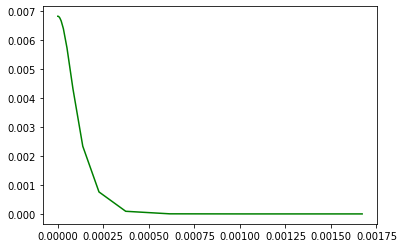

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


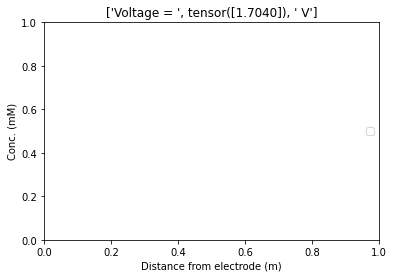

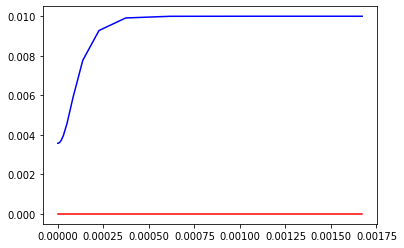

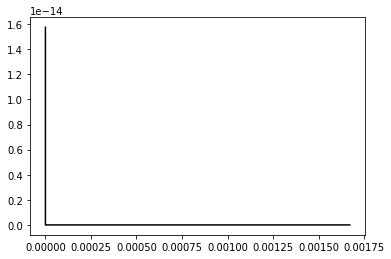

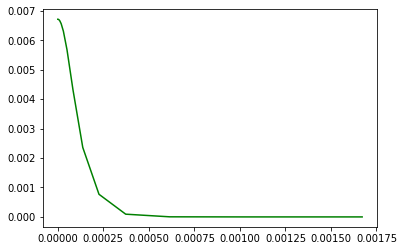

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


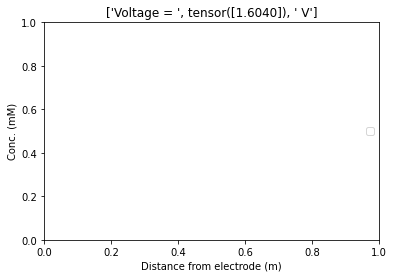

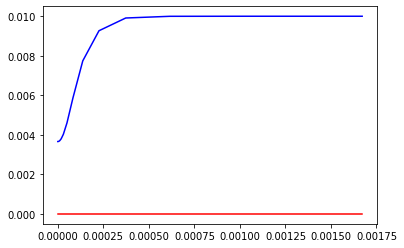

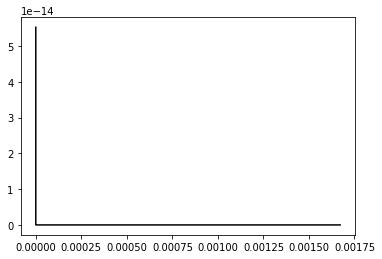

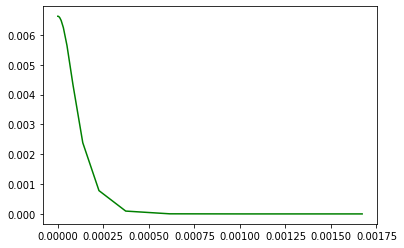

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


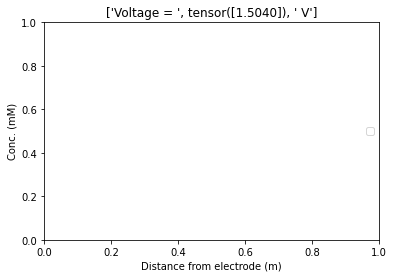

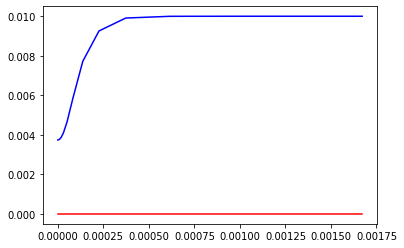

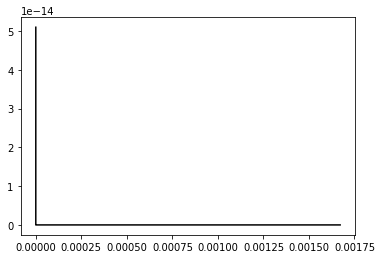

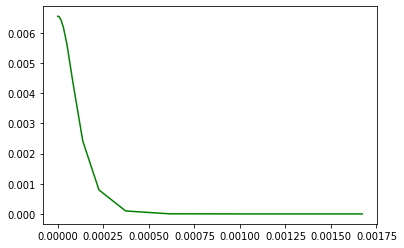

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


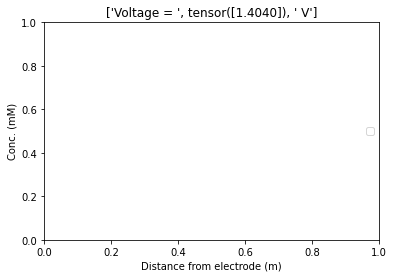

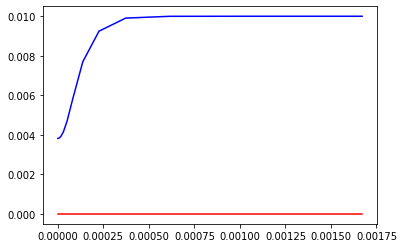

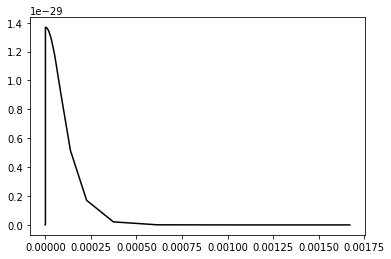

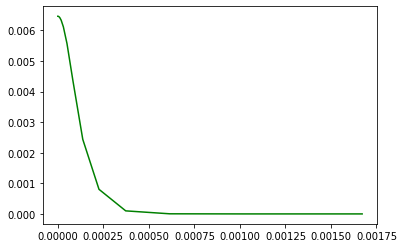

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


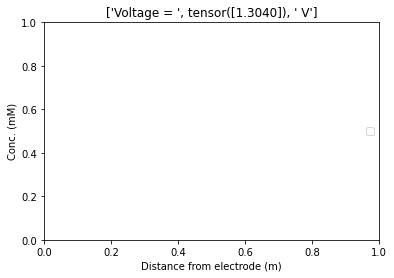

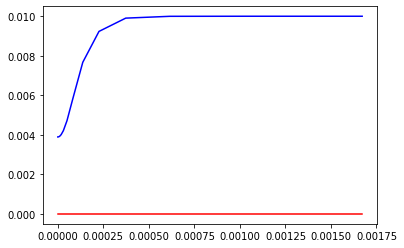

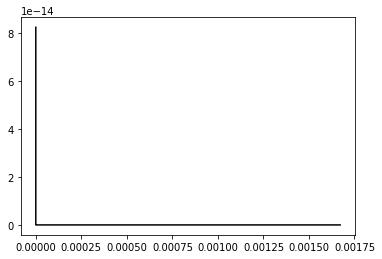

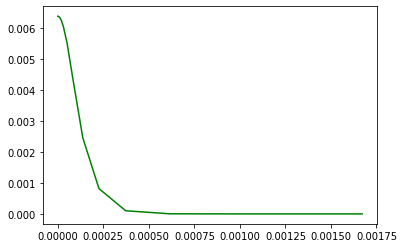

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


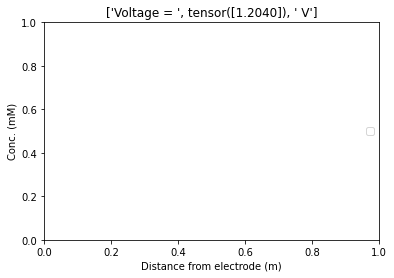

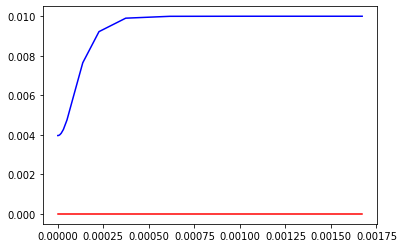

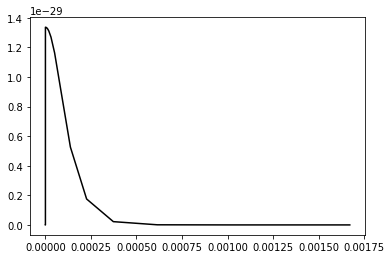

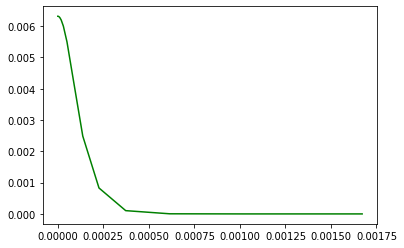

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


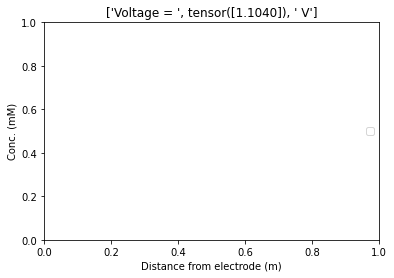

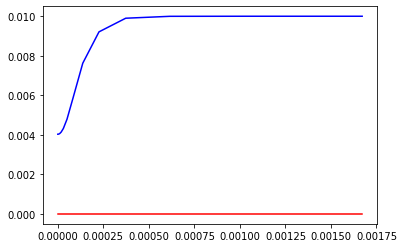

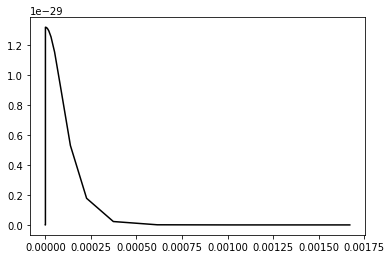

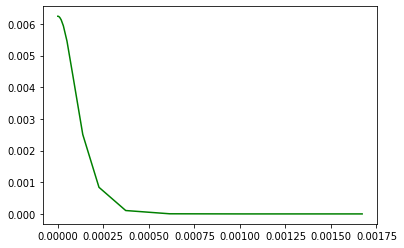

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


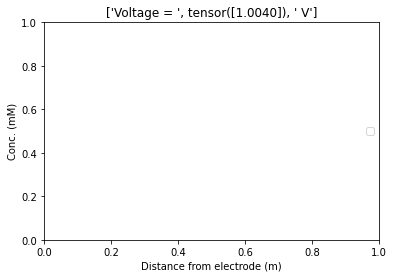

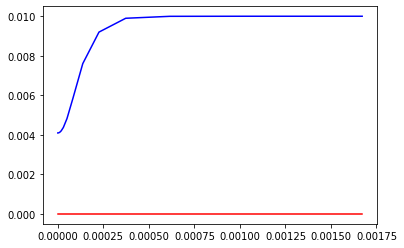

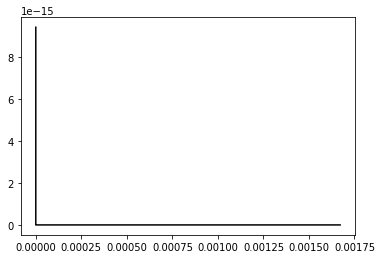

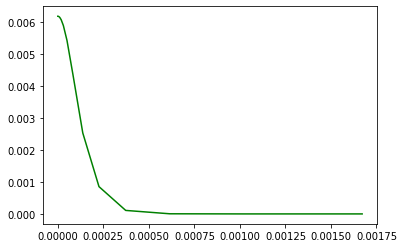

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


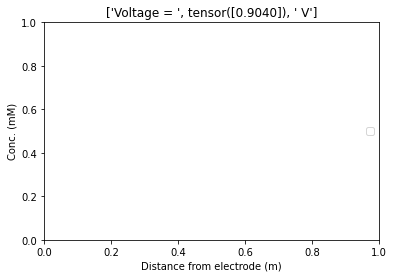

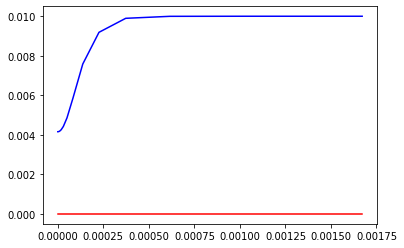

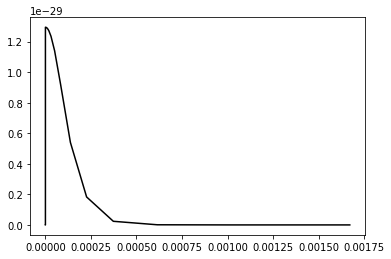

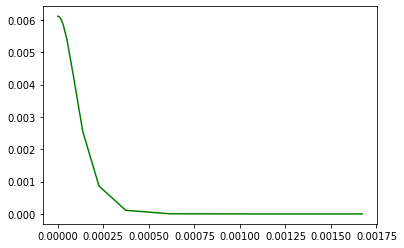

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


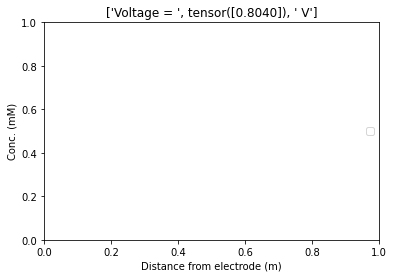

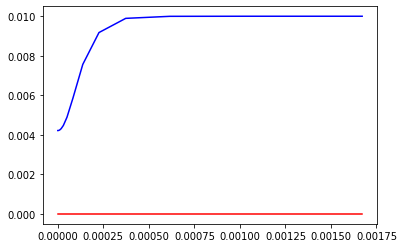

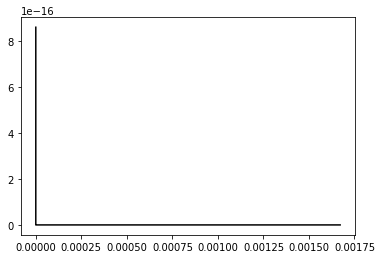

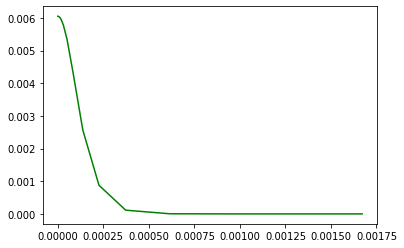

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


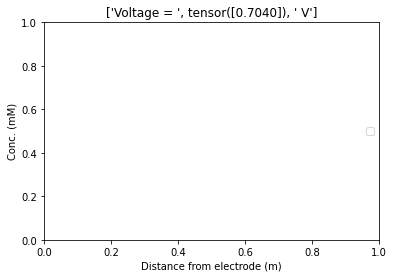

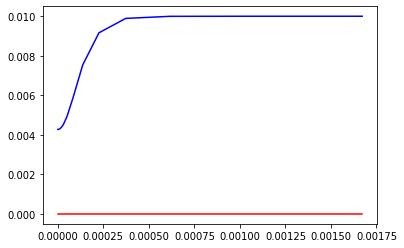

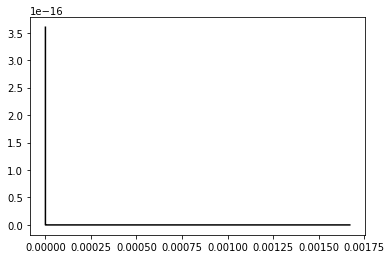

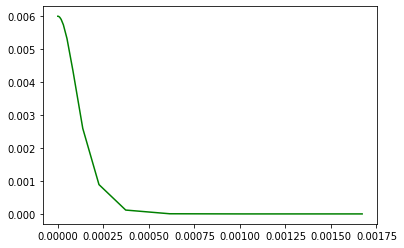

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


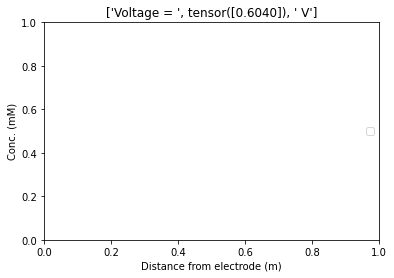

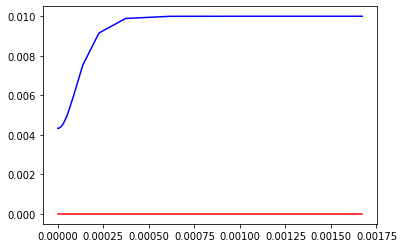

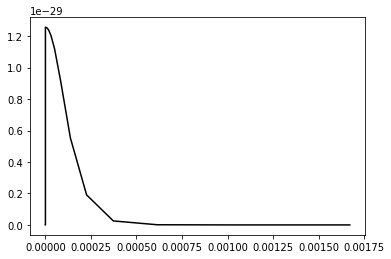

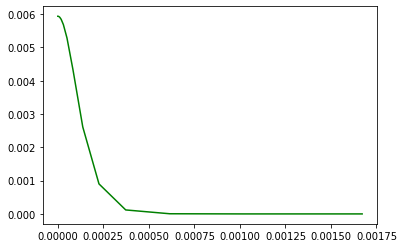

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


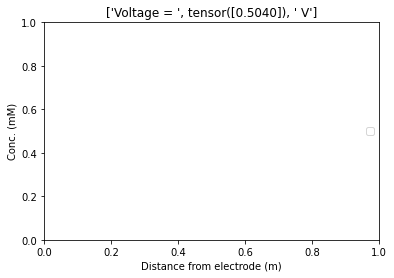

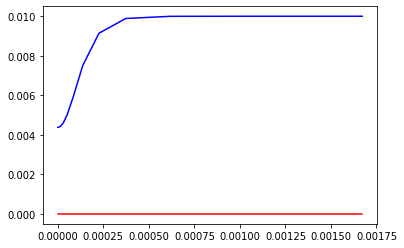

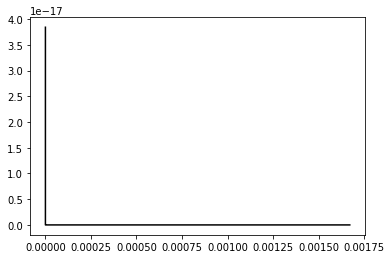

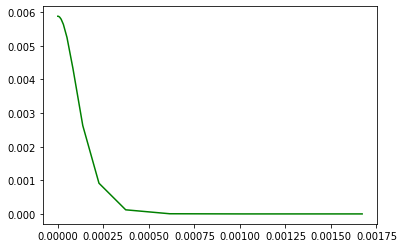

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


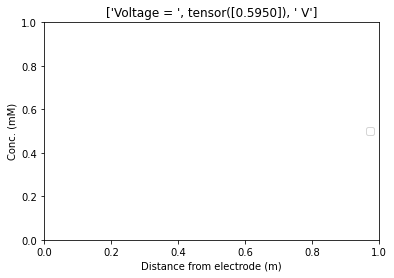

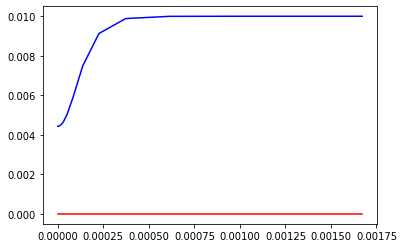

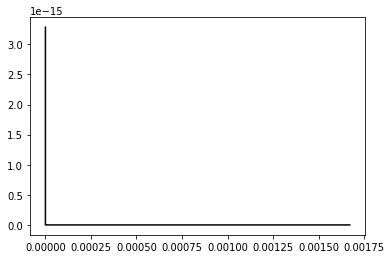

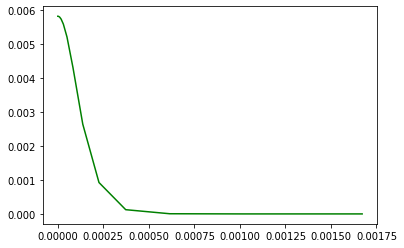

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


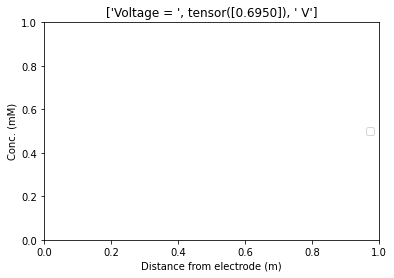

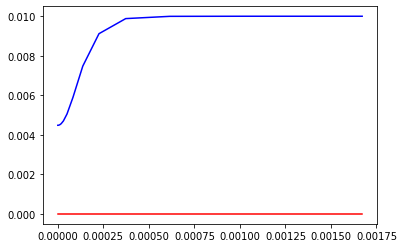

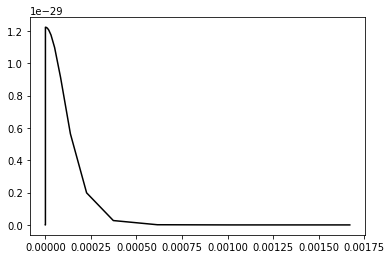

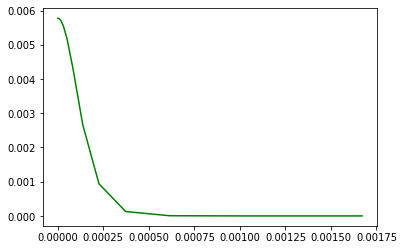

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


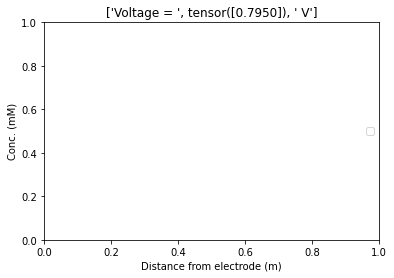

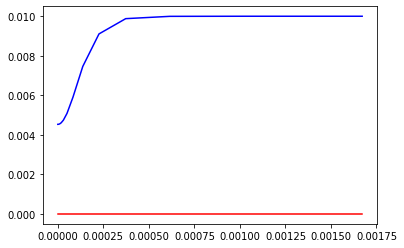

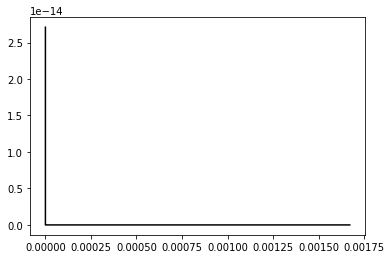

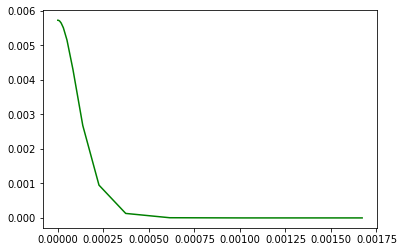

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


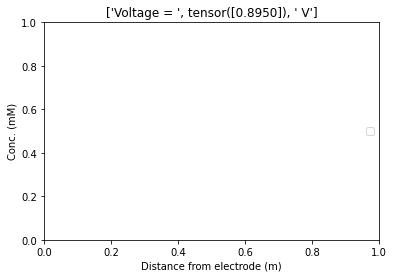

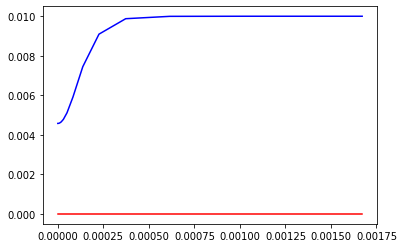

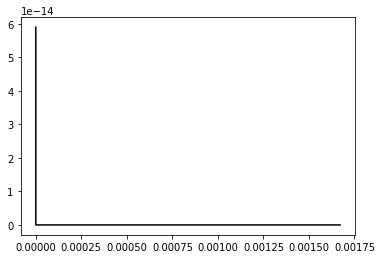

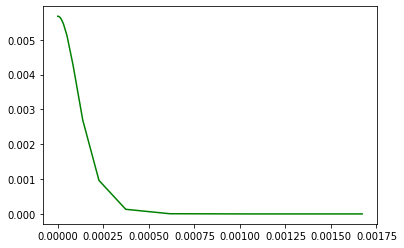

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


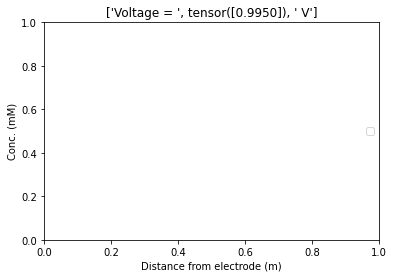

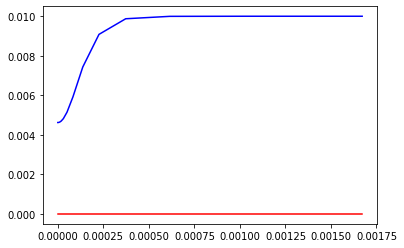

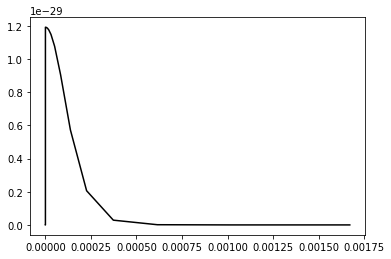

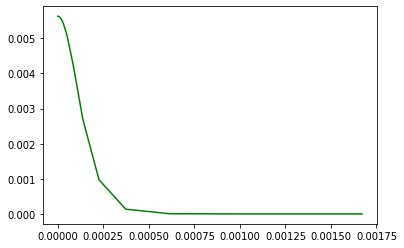

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


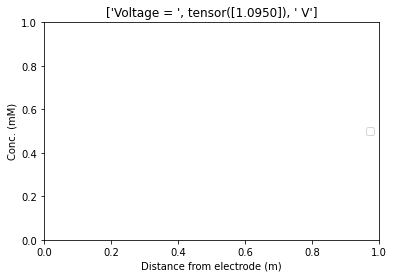

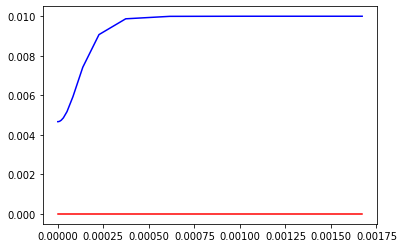

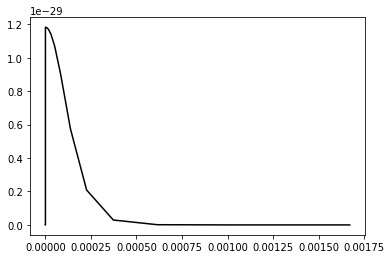

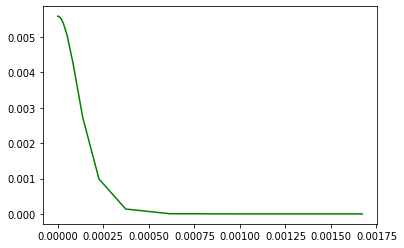

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


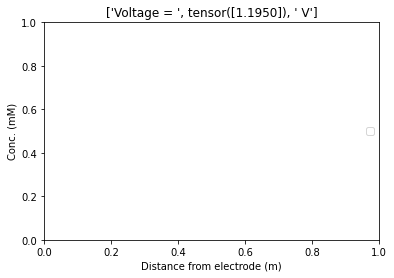

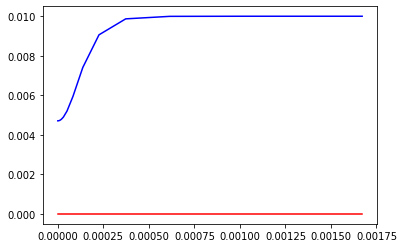

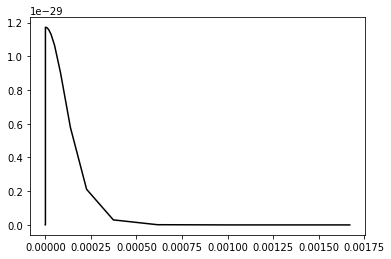

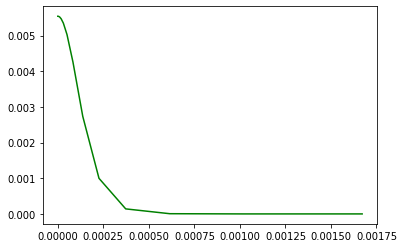

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


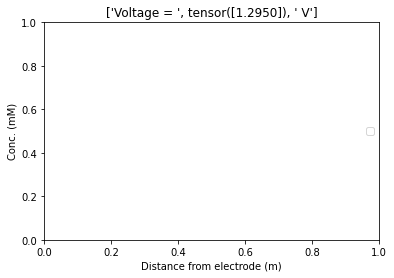

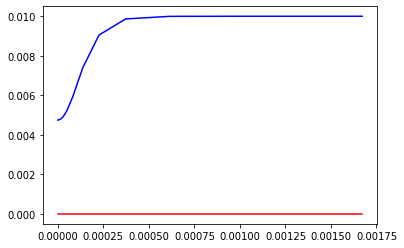

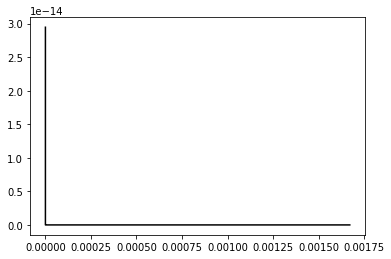

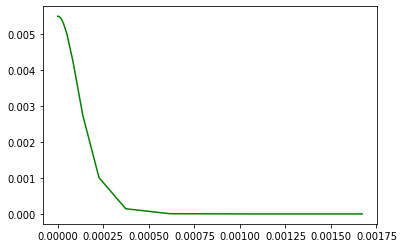

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


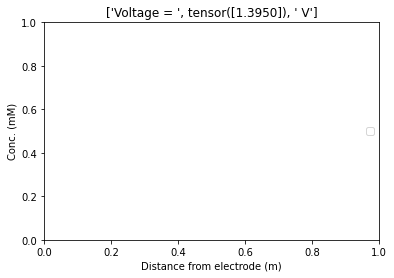

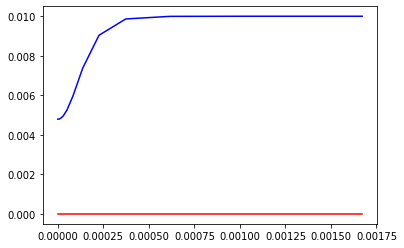

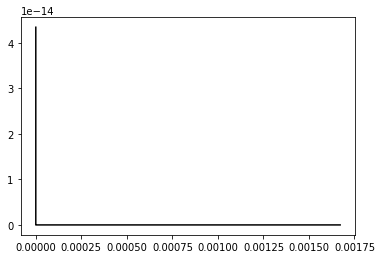

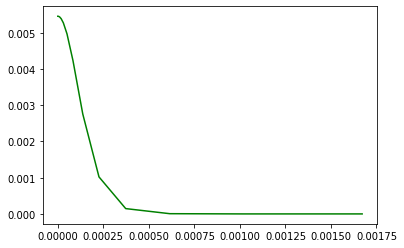

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


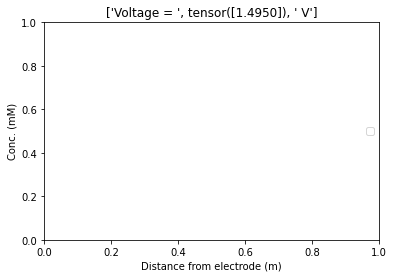

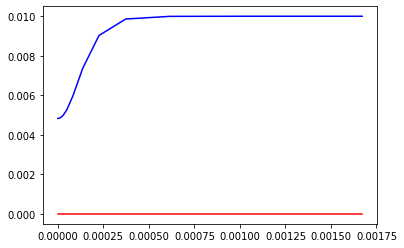

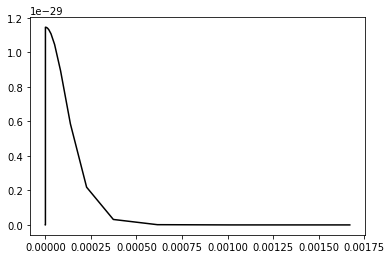

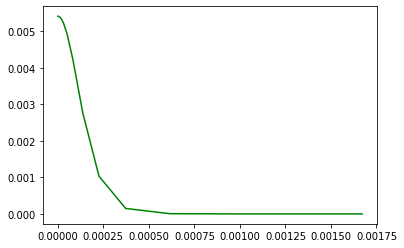

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


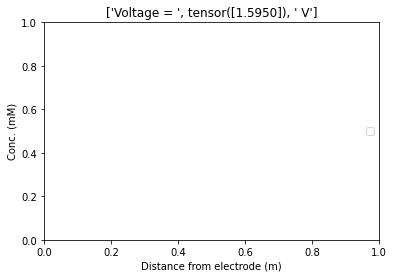

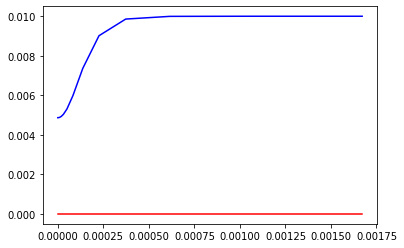

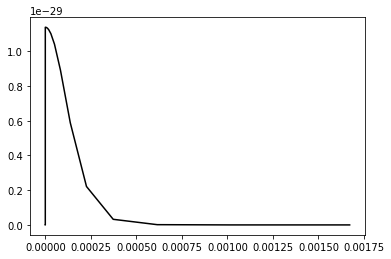

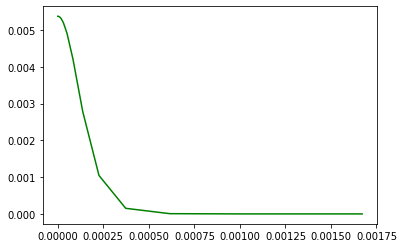

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


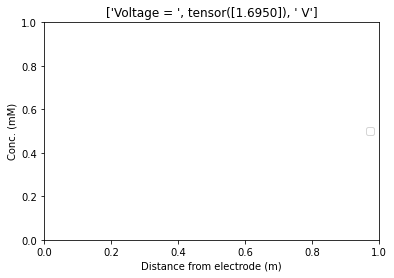

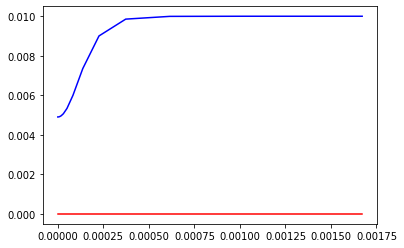

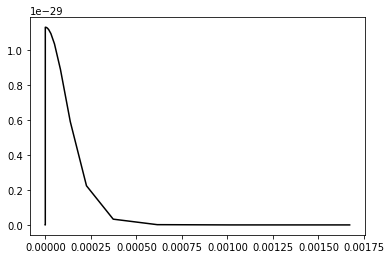

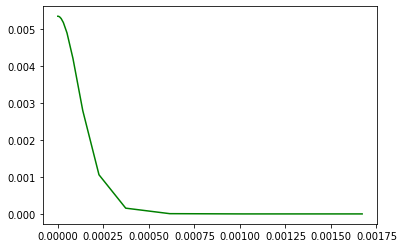

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


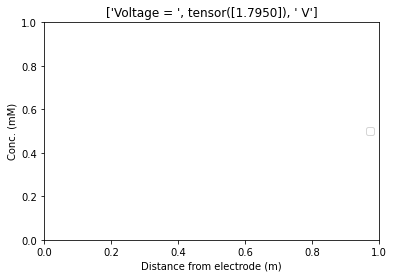

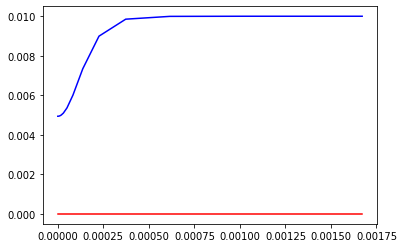

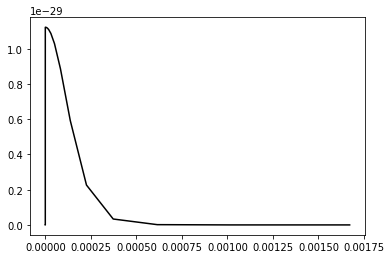

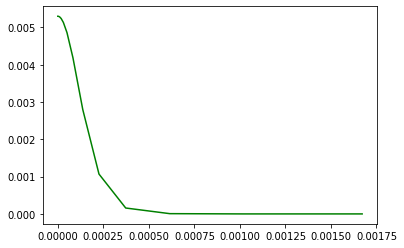

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


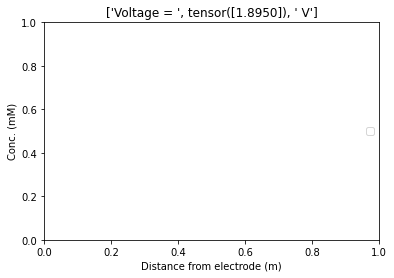

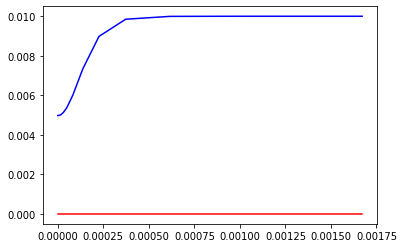

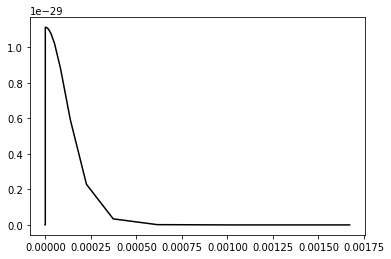

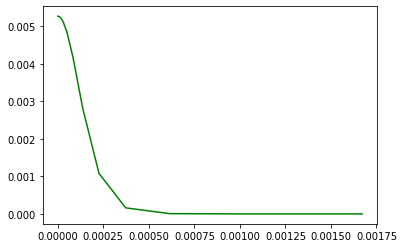

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


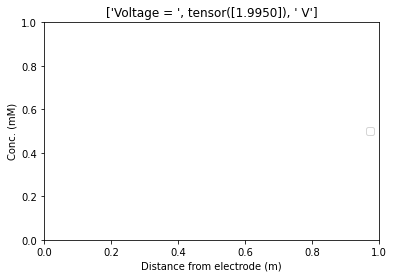

In [ ]:
for E in Evt:
  
  k1f = ks1 * math.exp((E-E10)*VT) * dx1 / DR
  k1b = ks1 * math.exp(-(E-E10)*VT) * dx1 / DP
  k3f = ks3 * math.exp((E-E30)*VT) * dx1 / DR
  k3b = ks3 * math.exp(-(E-E30)*VT) * dx1 / DP

  #set values for row 0
  Dopt[0] = 0
  Dopt[0, 0] = -1 - k1f
  Dopt[0, 1] = 1
  Dopt[0, N+1] = k1b * Cold2[0]
  Dopt[0, 2*N+2] = k1b * Cold1[0]

  #set values for row N+1
  Dopt[N+1] = 0
  Dopt[N+1, 0] = k1f
  Dopt[N+1, N+1] = -1 - k1b * Cold2[0] - k3f
  Dopt[N+1, N+2] = 1
  Dopt[N+1, 2*N+2] = k3b - k1b * Cold1[0]

  #set values for row 2*(N+1)
  Dopt[2*N+2] = 0
  Dopt[2*N+2, 0] = k1f
  Dopt[2*(N+1), 2*(N+1)] = -1 - k1b * Cold1[0] - k3b
  Dopt[2*N+2, 2*N+3] = 1
  Dopt[2*(N+1), N+1] = k3f - k1b * Cold2[0]

  for i in range(2*N+3, 3*N+2):
    Dopt[i] = 0
    Dopt[i, i] = D3[i-2*N-3] + k4fs
    Dopt[i, i-1] = -D1[i-2*N-3]
    Dopt[i, i+1] = -D2[i-2*N-3]
    Dopt[i, i+N+1] = -k4bs

  for i in range(3*N+4, 4*N+3):
    Dopt[i] = 0
    Dopt[i, i] = D3[i-3*N-4] + k4bs
    Dopt[i, i-1] = -D1[i-3*N-4]
    Dopt[i, i+1] = -D2[i-3*N-4]
    Dopt[i, i-N-1] = -k4fs

  Cnew, LU = torch.solve(Cold.double(), Dopt.double())
  Cnew[Cnew.lt(0)] = 0
  Cnew[Cnew.gt(0.01)] = 0.01

  Istor1[count,:] = DR*(Cnew[1] - Cnew[0])/dx1
  Istor2[count,:] = DR* (Cnew[N+2] - Cnew[N+1])/dx1

  if count % 100 == 0:
    plt.figure(count)
    plt.plot(x[0:(N+1)],Cnew[0:(N+1)],'-b')
    plt.plot(x[(N+1):(2*N+2)],Cnew[(N+1):(2*N+2)],'-r')
    plt.show()
    plt.plot(x[(2*N+2):(3*N+3)],Cnew[(2*N+2):(3*N+3)],'-k')
    plt.show()
    plt.plot(x[(3*N+3):(4*N+4)],Cnew[(3*N+3):(4*N+4)],'-g')
    plt.show()
    plt.title(['Voltage = ',E,' V'])
    plt.ylabel('Conc. (mM)')
    plt.xlabel('Distance from electrode (m)')
    plt.legend((1,2),('Reactant','Product'),loc=5)
    plt.show()
  
  #import pdb; pdb.set_trace()
  
  Cold[0:4*N+3] = Cnew[0:4*N+3]
  ColdR[0:N] = Cnew[0:N]
  Cold1[0:N] = Cnew[(N+1) : (2*N+1)]
  Cold2[0:N] = Cnew[(2*N+2) : (3*N+2)]
  Cold3[0:N] = Cnew[(3*N+3) : (4*N+3)]
  
  Cold[0] = k1b * Cold1[0] * Cold2[0]
  Cold[N+1] = -k1b * Cold1[0] * Cold2[0]
  Cold[2*N+2] = -k1b * Cold1[0] * Cold2[0]
  Cold[3*N+3] = 0
  
  Cold[N] = CR0
  Cold[2*N+1] = CP10
  Cold[3*N+2] = CP20
  Cold[4*N+3] = CP30
  
  count = count + 1
  #import pdb; pdb.set_trace()


In [ ]:
Cnew_test, LU = torch.solve(Cold, Dopt)
print(torch.dist(Cold.double(), torch.mm(Dopt.double(),Cnew_test.double())))

tensor(1.2565e-12, dtype=torch.float64)


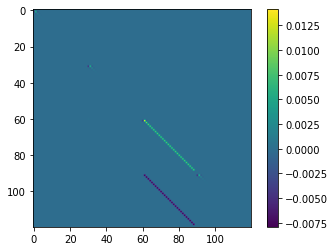

In [ ]:
plt.imshow((Dopt/(1e9)).tolist())
plt.colorbar()

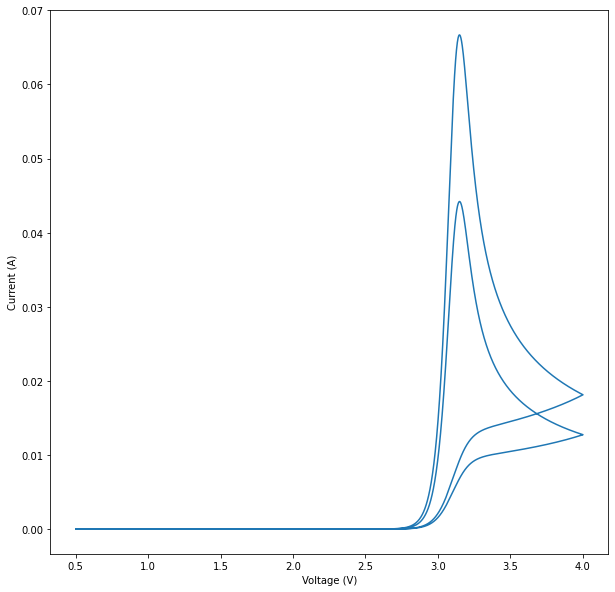

In [ ]:
Istor = (Istor1 + Istor2) * F
plt.figure(figsize=(10,10))    
plt.plot(Evt,Istor)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
#plt.ylim(-0.0000005, 0.000001)
plt.show()

In [ ]:
Evt_tensor = Evt.view(-1)
Istor_tensor = Istor.view(-1)
#Istor_tensor[Evt_tensor.le(2.0)] = 0
max_val, max_idx = Istor_tensor.max(0)
min_val, min_idx = Istor_tensor.min(0)
print ('max Evt', Evt_tensor[max_idx], 'max Istor', Istor_tensor[max_idx])
print ('min Evt', Evt_tensor[min_idx], 'min Istor', Istor_tensor[min_idx])

max Evt tensor(3.1490) max Istor tensor(0.0667, dtype=torch.float64)
min Evt tensor(0.6120) min Istor tensor(-7.5191e-08, dtype=torch.float64)


In [ ]:
print("Evt =", Evt.view(-1).tolist())
print("Isor =", Istor.view(-1).tolist())

Evt = [2.000999927520752, 2.002000093460083, 2.003000020980835, 2.003999948501587, 2.005000114440918, 2.00600004196167, 2.006999969482422, 2.007999897003174, 2.009000062942505, 2.009999990463257, 2.010999917984009, 2.01200008392334, 2.013000011444092, 2.0139999389648438, 2.015000104904175, 2.0160000324249268, 2.0169999599456787, 2.0179998874664307, 2.0190000534057617, 2.0199999809265137, 2.0209999084472656, 2.0220000743865967, 2.0230000019073486, 2.0239999294281006, 2.0250000953674316, 2.0260000228881836, 2.0269999504089355, 2.0280001163482666, 2.0290000438690186, 2.0299999713897705, 2.0309998989105225, 2.0320000648498535, 2.0329999923706055, 2.0339999198913574, 2.0350000858306885, 2.0360000133514404, 2.0369999408721924, 2.0380001068115234, 2.0390000343322754, 2.0399999618530273, 2.0409998893737793, 2.0420000553131104, 2.0429999828338623, 2.0439999103546143, 2.0450000762939453, 2.0460000038146973, 2.046999931335449, 2.0480000972747803, 2.0490000247955322, 2.049999952316284, 2.051000118

In [ ]:
a = torch.ones(2,3)
b=a.data.clone()
b[0]= 0 
print (a)
#b = torch.zeros(2,3)
#print (a.index_select(0, torch.LongTensor([1])))
#a.index_select(0, torch.LongTensor([1]))[:] = b[1:]
#print (a)

#a = [1,2,3]
#b = a
#b[1] = 0
#print (a)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
